# CA2 Part 1 (Time Series Forecasting)

Done By: Darius Khoo  
  

Admin Number: 2222259  
  

Class: DAAA/FT/2A/06  
  

---

### **Background**
Using the Energy Consumption Dataset to train time series models and forecast
the gas consumption, electricity consumption and water consumption in the
future.

### **Task** 
- Write the code to solve the time series prediction. For the time series model,use Statsmodels only (do not use other 3rd party libraries such as autoML).

- Tune the hyperparameters of the time series model to maximize the accuracy for training data and testing data prediction.

- Write a short report detailing your implementation, your experiments and analysis in the Jupyter notebook (along with your python code and comments).

- Create a set of slides with the highlights of your Jupyter notebook. Explain the time series prediction process, model building and evaluation. Write your conclusions.

In [743]:
# pip install prophet

In [506]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import datetime
from dateutil.relativedelta import relativedelta



# Statistical Analysis
# Statistical Tests, Plots, and Visualizations
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pipelines
from sklearn.pipeline import Pipeline

# Forecasting
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# Hyperparameter Tuning
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer
sns.set()

from warnings import filterwarnings 
filterwarnings('ignore')
rng = np.random.RandomState(42)

df = pd.read_csv('./data/Energy Consumption Dataset.csv')

In [507]:
df.head(8)

,DATE,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
0,1/1/1990,18.0,725.1,548.8
1,1/2/1990,15.8,706.7,640.7
2,1/3/1990,17.3,624.5,511.1
3,1/4/1990,18.9,574.7,515.3
4,1/5/1990,22.0,553.2,488.4
5,1/6/1990,23.4,580.9,503.2
6,1/7/1990,24.6,626.2,448.3
7,1/8/1990,24.8,632.5,411.7


In [508]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE                           397 non-null    object 
 1   Gas Consumption (tons)         397 non-null    float64
 2   Electricity Consumption (MWh)  397 non-null    float64
 3   Water Consumption (tons)       397 non-null    float64
dtypes: float64(3), object(1)
memory usage: 12.5+ KB


In [509]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gas Consumption (tons),397.0,23.785139,4.903452,11.6,20.2,23.5,27.9,46.0
Electricity Consumption (MWh),397.0,888.472544,153.877594,553.2,771.1,897.8,1005.2,1294.0
Water Consumption (tons),397.0,484.953652,133.908863,44.4,384.4,487.4,580.2,811.0


>As we can infer from these, the dataset looks quite normal, with no null values,however just from value inspection there seem to be some skewness in electricity and water consumption.

In [510]:
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y")

display(df.dtypes)

df.set_index("DATE", inplace=True)

DATE                             datetime64[ns]
Gas Consumption (tons)                  float64
Electricity Consumption (MWh)           float64
Water Consumption (tons)                float64
dtype: object

> I set the Date column as a datetime dtype and made it my index 

In [511]:
print(f'the dates are from {df.index.min()} to {df.index.max()}')
print(f'{df.index[0]}, {df.index[1]}')

the dates are from 1990-01-01 00:00:00 to 2023-01-01 00:00:00
1990-01-01 00:00:00, 1990-02-01 00:00:00


> This tells me the dataset goes by month where each record is 1 month after the other, it also tells me the start date and end date of the dataset

---

## Univariate Analysis

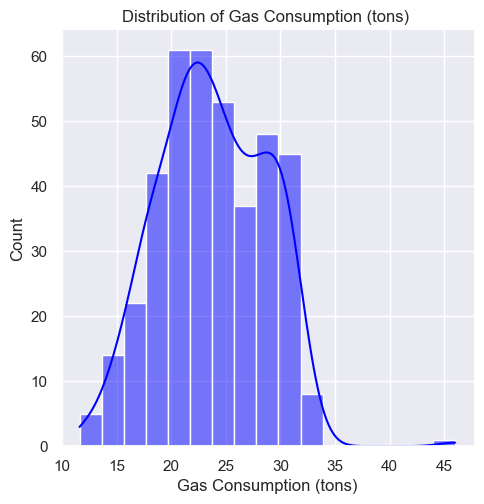

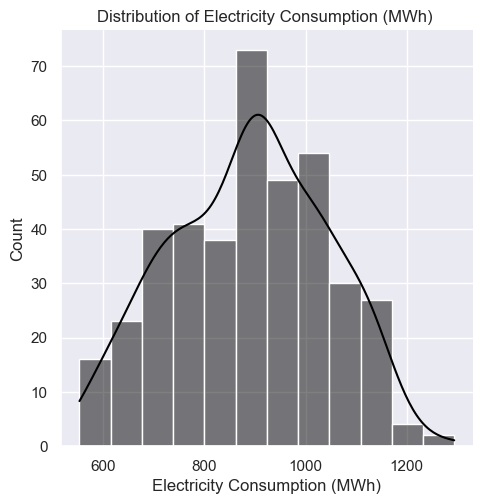

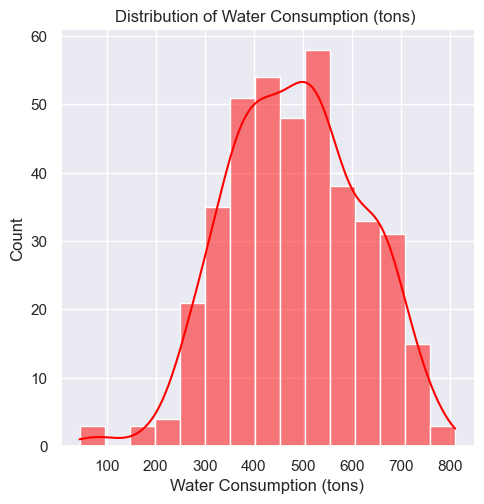

In [515]:
x_values = ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']
colors = ['blue', 'black', 'red']

for x, color in zip(x_values, colors):
    sns.displot(x=x, kde=True, height=5, data=df, color=color)
    plt.title(f"Distribution of {x} ")
    plt.show()

> We can infer that everything seems quite normally distributed except for gas consumption being skewed, however that doesn't really tell you much since this is a time series data, evaluate as a whole often won't tell you the whole story, lets to more test to breakdown the data

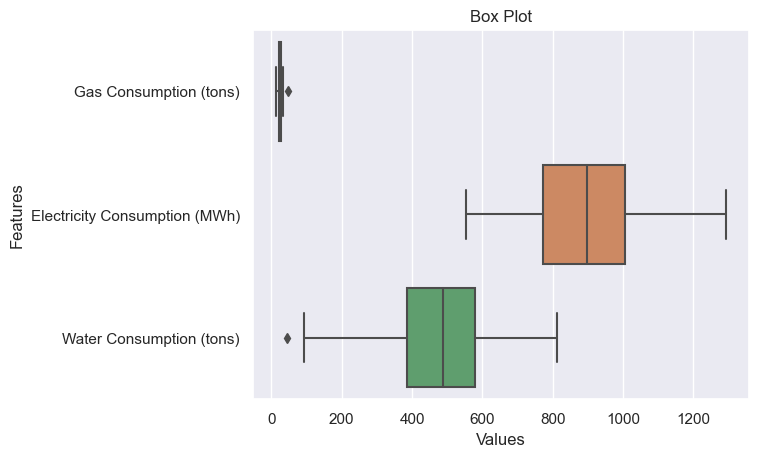

In [516]:
sns.boxplot(data=df , orient= 'h')

plt.xlabel("Values")
plt.ylabel("Features")
plt.title("Box Plot")

plt.show()

> From the box plot we can see only around 2 outlier values, however that doesn't mean there are only 2 outliers i will explain further later on below

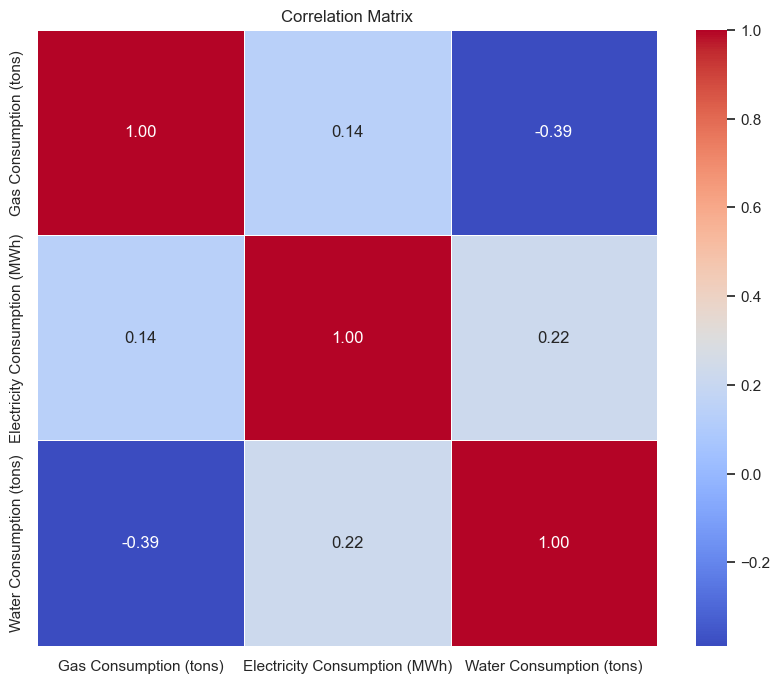

In [517]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

> For the correlation it seems good with nothing really having a high/moderate correlation with each other with the highest being 0.39 between water and gas which isn't high at all

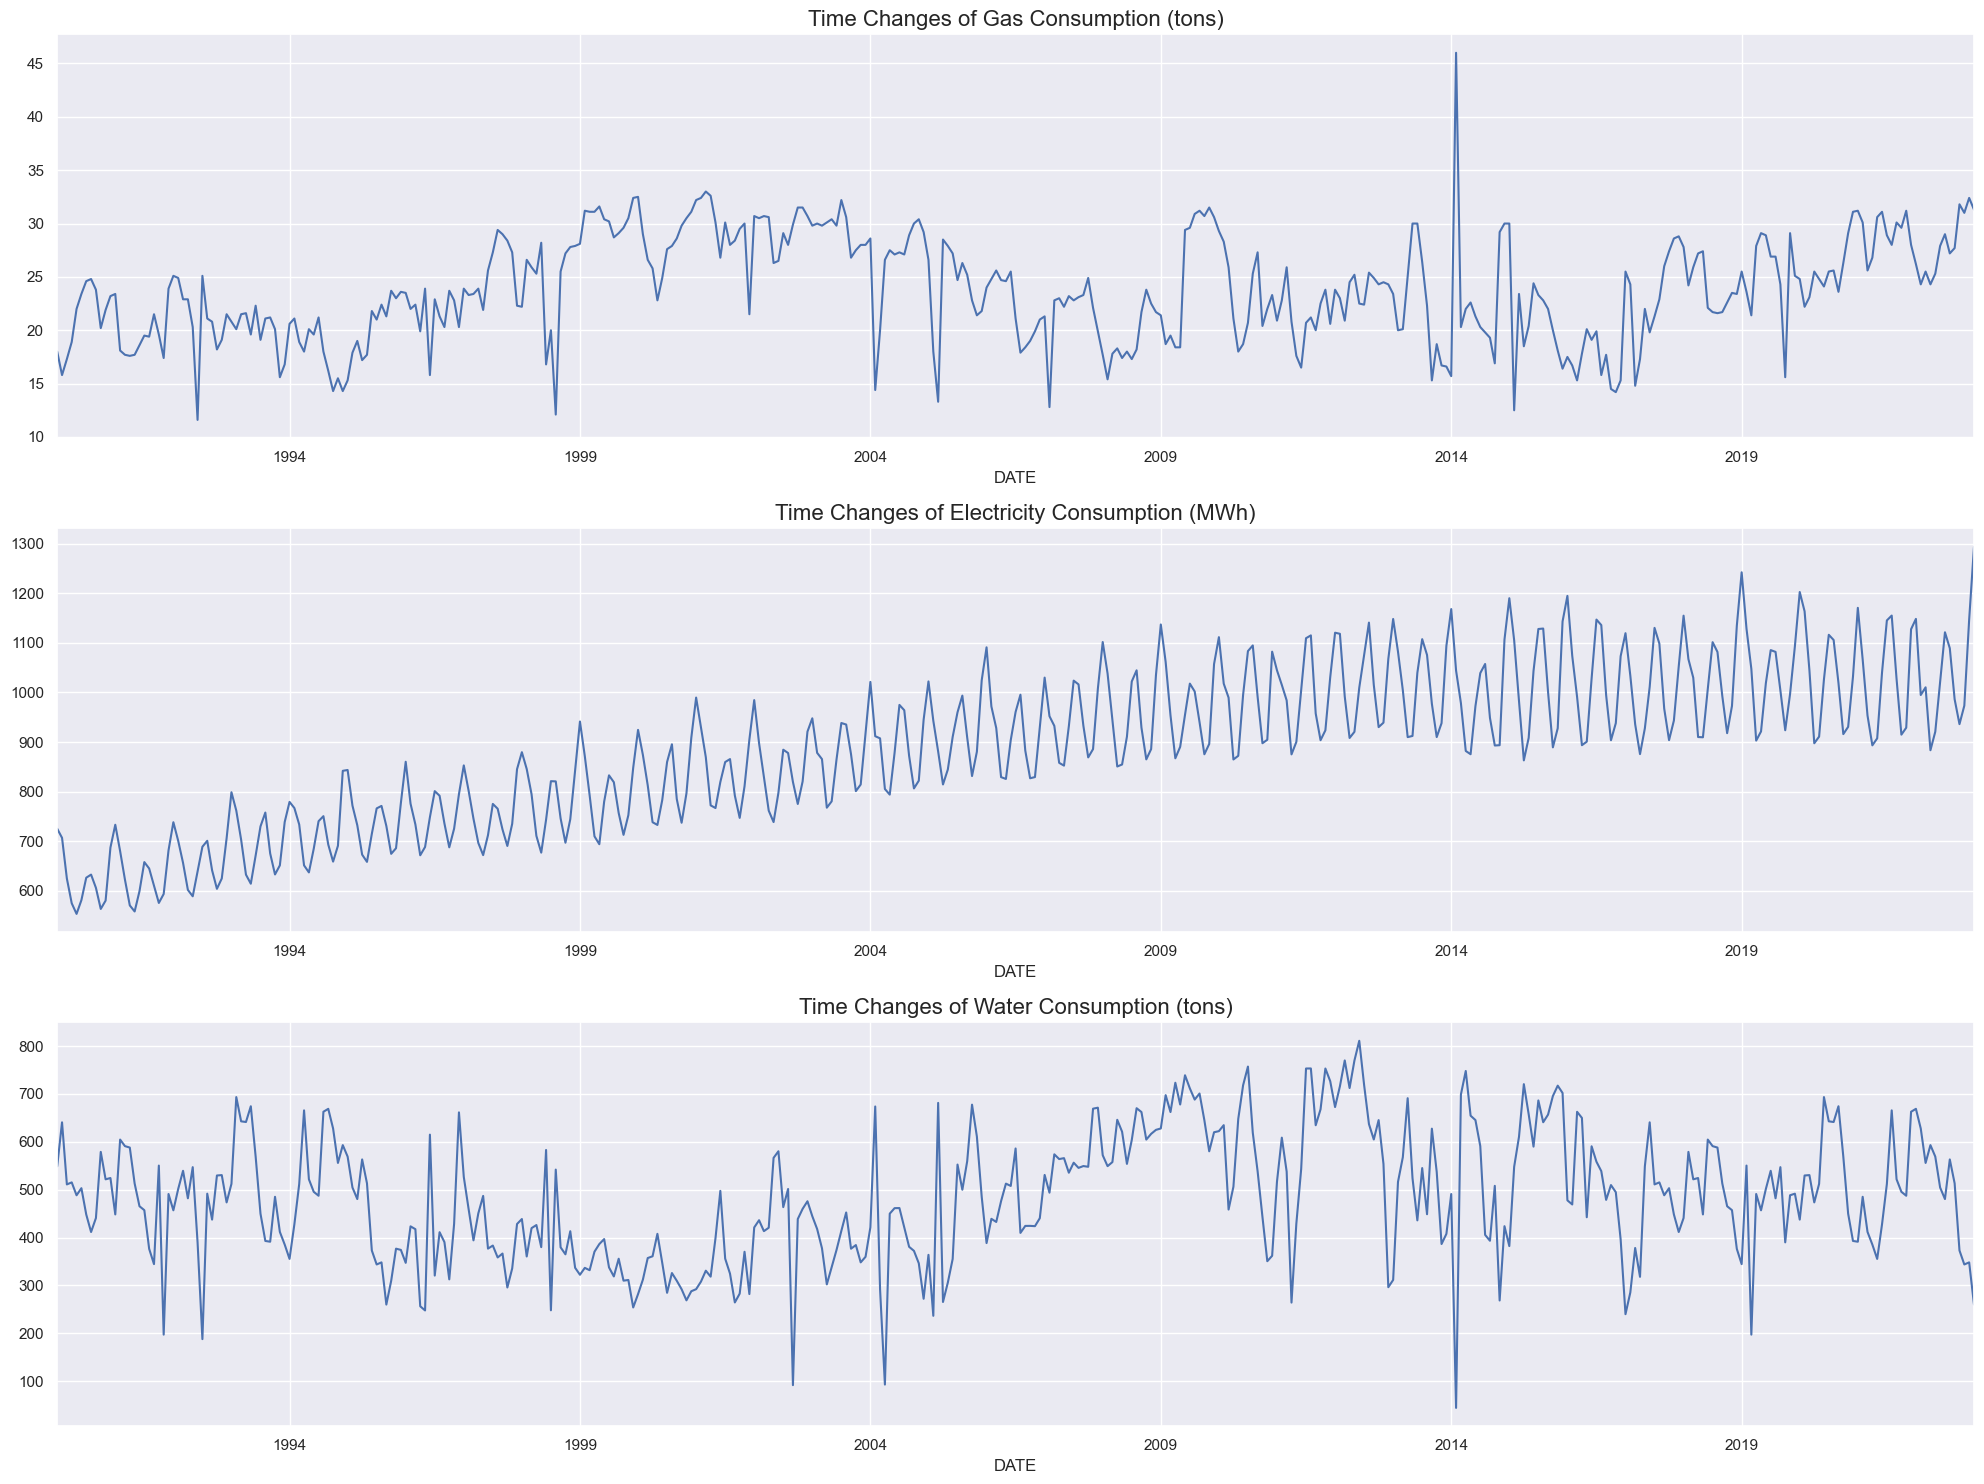

In [518]:
continuous = ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']
fig = plt.figure(tight_layout=True, figsize=(20, 15))
for i, column in enumerate(continuous):
    ax = fig.add_subplot(len(continuous), 1, i + 1)
    df[column].plot(ax=ax)
    ax.set_title("Time Changes of " + column, fontsize=16)
plt.show()

>I have plotted out the 3 time series graphs and in first glance i can already see that electricity has an upward linear trend, the rest look quite okay however this goes back to the outliers through visual inspection of this graph we can already see more than a few outlier values, so why is that? it will be discussed later on 

## Time Series Decomposition

Before we do anything we need to perform a few test to check the dataset, that includes
<!-- 
- Autocorrelation Test
- Stationarity Test
- Seasonality Test
- Unit Root Test
- Granger Causality Test
- Residual Analysis -->

- Test for Stationarity 
- Residual Analysis
- Outlier Analysis 
- etc (with many more)

First lets start with the most basic test which is test for stationarity, many models such as ARIMA requires the data to be stationary to carry out forecasting, hence we need to check each feature for stationarity, if it happens to not stationary we need to change that later on

Lets use the Dicky Fuller Test to evaluate

o P-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.  


o P-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [520]:
def evaluate_stationarity(data, columns, significance_level=0.05):
    for column in columns:
        adftest = adfuller(data[column])
        
        print("Column:", column)
        print("Number of observations:", adftest[3])
        print()
        print("Significance Level:", significance_level)
        print("p-value:", adftest[1])


        print()

        for key, value in adftest[4].items():
            print(f"Critical Value at {key}:", value)
        print()
        print('Test Statistic Value:', adftest[0])
        print()
        if adftest[1] < significance_level:
            print('Since p-value < significance level we reject the Null Hypothesis')
            print('The data is Stationary')
        elif adftest[1] > significance_level:
            print('Since p-value > significance level we Accept the Null Hypothesis')
            print('The data is Non-Stationary')

        print('-' * 50)
        print()


columns =  ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']  # Specify the columns to evaluate

evaluate_stationarity(df, columns)


Column: Gas Consumption (tons)
Number of observations: 390

Significance Level: 0.05
p-value: 0.01081065170706051

Critical Value at 1%: -3.4472291365835566
Critical Value at 5%: -2.8689795375849223
Critical Value at 10%: -2.5707330834976987

Test Statistic Value: -3.4043743333182728

Since p-value < significance level we reject the Null Hypothesis
The data is Stationary
--------------------------------------------------

Column: Electricity Consumption (MWh)
Number of observations: 381

Significance Level: 0.05
p-value: 0.18621802300336632

Critical Value at 1%: -3.4476305904172904
Critical Value at 5%: -2.869155980820355
Critical Value at 10%: -2.570827146203181

Test Statistic Value: -2.256980549592542

Since p-value > significance level we Accept the Null Hypothesis
The data is Non-Stationary
--------------------------------------------------

Column: Water Consumption (tons)
Number of observations: 392

Significance Level: 0.05
p-value: 8.984549388336973e-05

Critical Value at 1%:

> When reading the whole output, we can see that for most of the features the data is stationary, with the only exception being the electricity consumption which was quite obvious even from visual inspection of the time series graph as it was in a upward trend

## KPSS test

i decided to double check the results by using another test for stationarity <u>KPSS test </u>

however this one is slightly different 

o P-value > 0.05: Fail to reject the null hypothesis (H0), the data is stationary.


o P-value <= 0.05: Reject the null hypothesis (H0), The data is not stationary

In [522]:
def kpss_test(data):
    for column in data.columns:
        result = kpss(data[column])

        # Extract test statistics and p-value
        test_statistic = result[0]
        p_value = result[1]
        critical_values = result[3]

        print(f"Column: {column}")
        print(f"KPSS Test Statistic: {test_statistic}")
        print(f"p-value: {p_value}")
        print("Critical values:")
        for key, value in critical_values.items():
            print(f"  {key}: {value}")

        if p_value < 0.05:
            print("The series is not stationary (reject the null hypothesis)")
        else:
            print("The series is stationary (fail to reject the null hypothesis)")
        print()

In [523]:
kpss_test(df)


Column: Gas Consumption (tons)
KPSS Test Statistic: 0.3402153835554435
p-value: 0.1
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is stationary (fail to reject the null hypothesis)

Column: Electricity Consumption (MWh)
KPSS Test Statistic: 3.531601452001429
p-value: 0.01
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is not stationary (reject the null hypothesis)

Column: Water Consumption (tons)
KPSS Test Statistic: 0.8388411776971113
p-value: 0.01
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is not stationary (reject the null hypothesis)



> The results are quite surprising, although the results matches for the first 2 feature (gas and electricity) however between the 2 test, the water consumption results are different, we can determine which one is correct immediately because through visual inspection the results are ambiguous.


>However i decided to follow the KPSS test results and assume that the data is stationary, Since it fully rejects the null hypothesis also its better to make sure that its stationary

In [524]:
df1 = pd.DataFrame()

df1['Differenced_water'] = df['Water Consumption (tons)'].diff().dropna()
df1['Differenced_electricity'] = df['Electricity Consumption (MWh)'].diff().dropna()
kpss_test(df1)

Column: Differenced_water
KPSS Test Statistic: 0.11112601659149662
p-value: 0.1
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is stationary (fail to reject the null hypothesis)

Column: Differenced_electricity
KPSS Test Statistic: 0.14519067668792815
p-value: 0.1
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is stationary (fail to reject the null hypothesis)



> After the first difference we can see that the features are now stationary, however a difference of lag 1 is not the only option for the d parameters in models its just for the baseline

## *Seasonality Decomposition*

We decompose the time series data to find out some useful analysis, such as trend, seasonality and residual

In [527]:
def plot_decomposition(data, column):
    decompose = seasonal_decompose(data[column])

    trend = decompose.trend
    seasonality = decompose.seasonal
    residual = decompose.resid

    print(f'the amount of datapoints per seasons is {len(seasonality.unique())}')
    
    fig, axs = plt.subplots(4, 1, figsize=(15, 12))
    axs[0].plot(data[column])
    axs[0].set_title('Original Time Series')

    axs[1].plot(trend)
    axs[1].set_title('Trend Component')

    axs[2].plot(seasonality)
    axs[2].set_title('Seasonality Component')

    axs[3].scatter(range(len(residual)), residual)
    axs[3].axhline(0, color='black', linestyle='--')  
    axs[3].set_title('Residual Component')
    plt.tight_layout()
    plt.show()


the amount of datapoints per seasons is 12


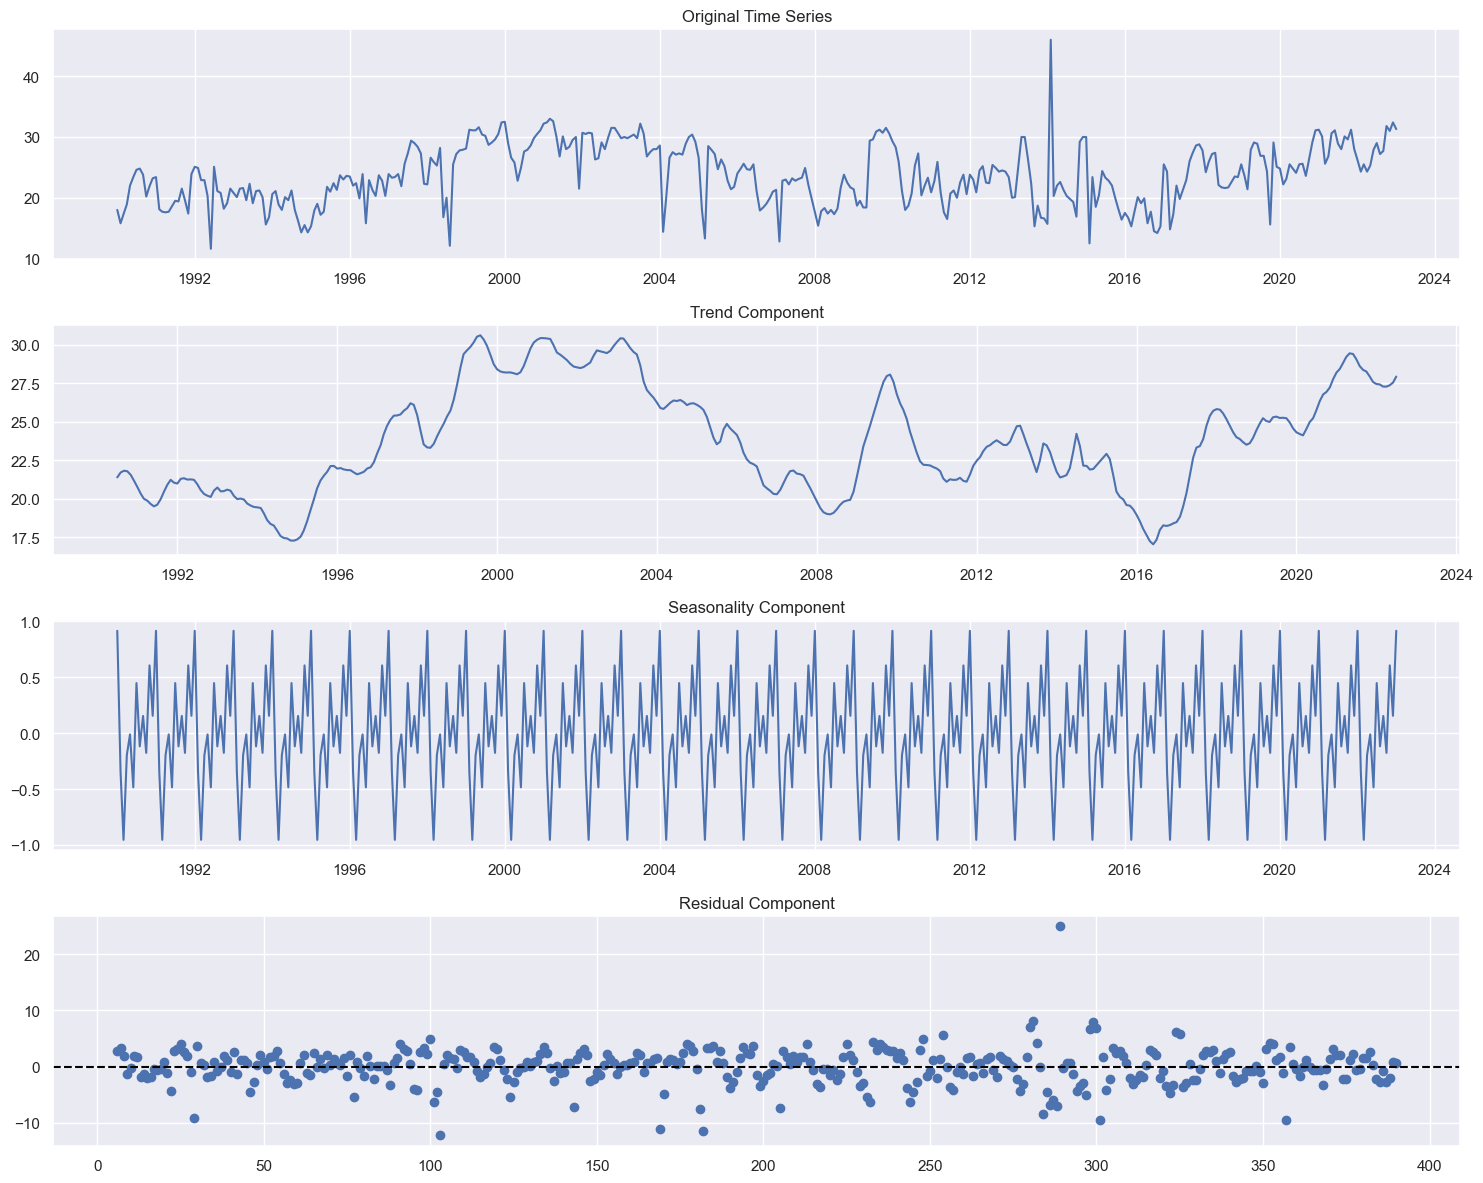

In [528]:
plot_decomposition(df, 'Gas Consumption (tons)')


> For Gas consumption there is not really a clear trend but there is seasonality,with 12 datapoint points being in 1 season basically 1 year is a season, there really isn't anything notable for the residual except for that 1 extreme value 

the amount of datapoints per seasons is 12


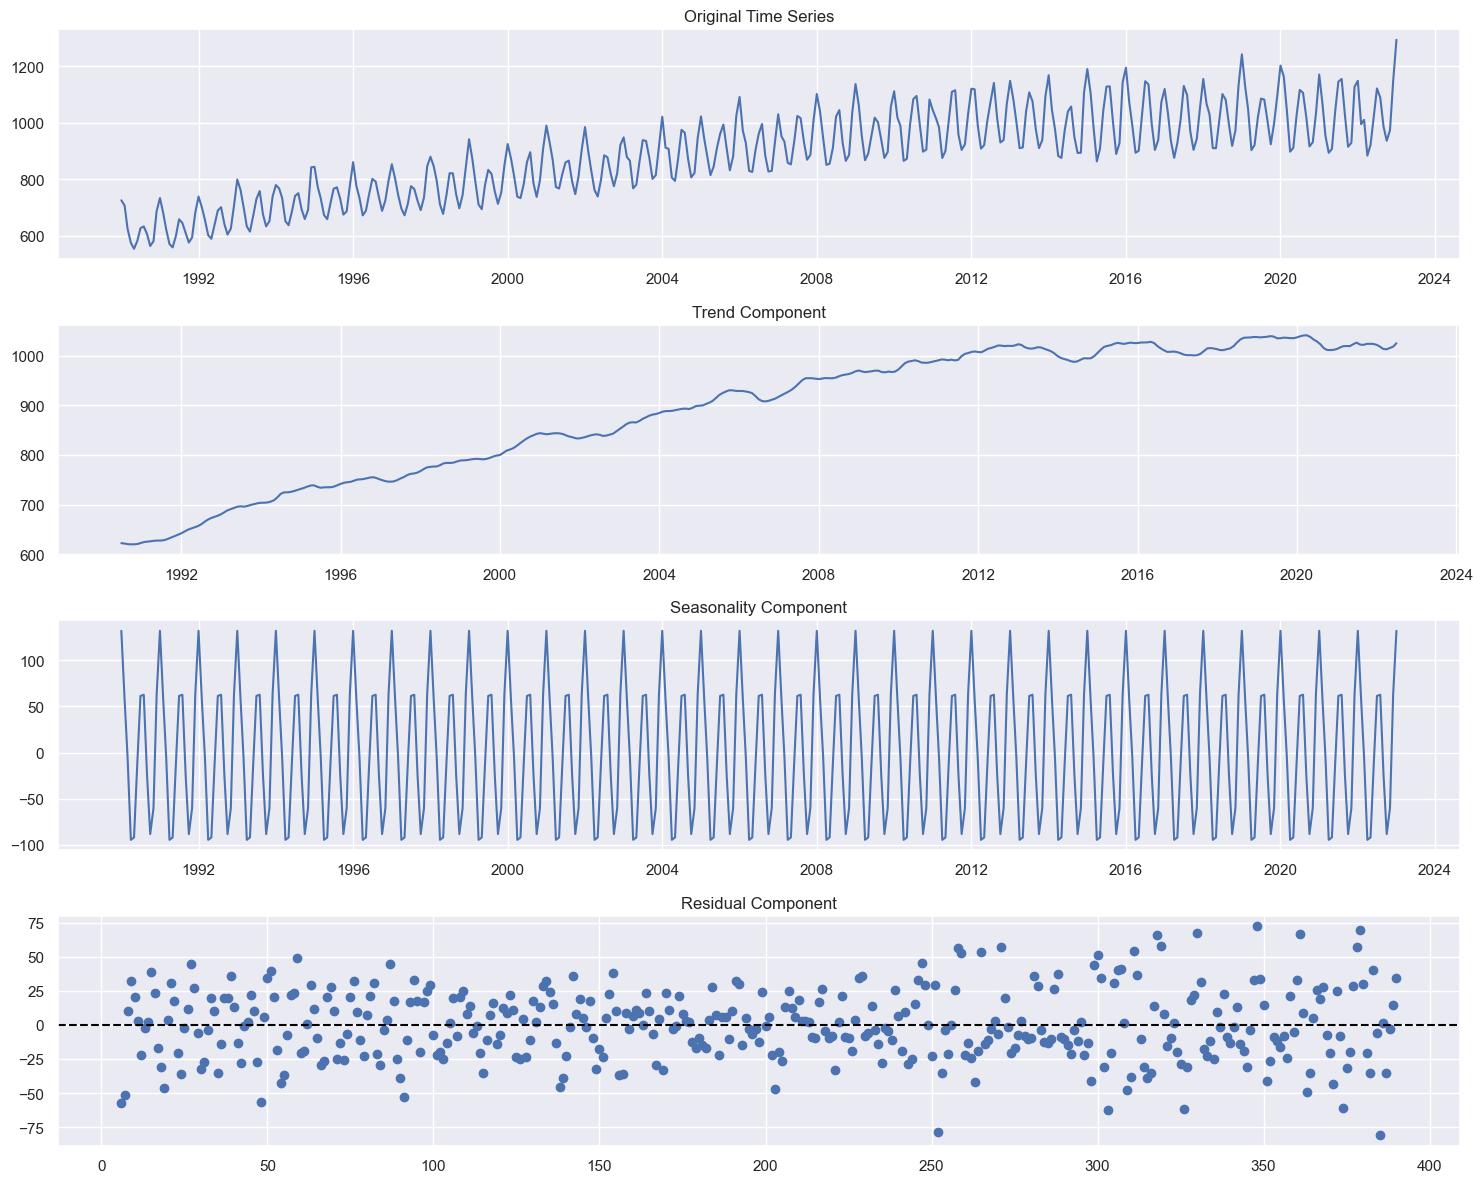

In [529]:
plot_decomposition(df, 'Electricity Consumption (MWh)')


> For the electricity consumption there is a clear upward trend, with seasonality of 12 datapoints, The residual shows the data points all over the place likely due to the upward trend

the amount of datapoints per seasons is 12


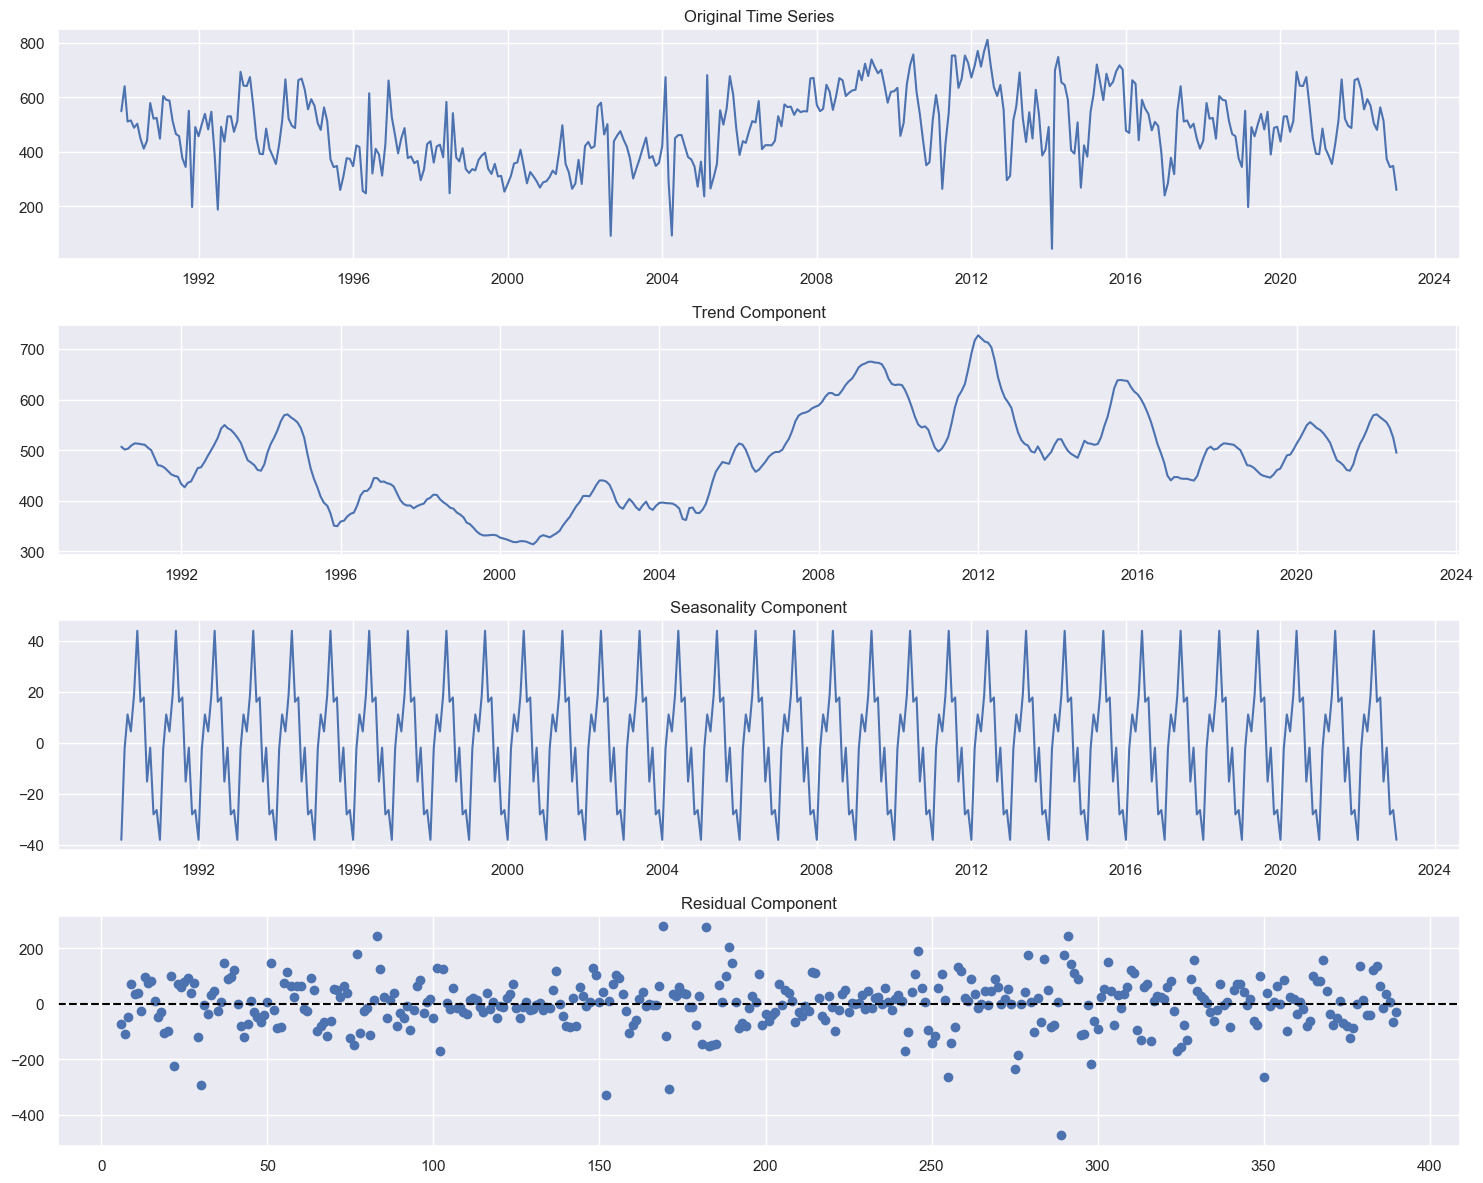

In [530]:
plot_decomposition(df, 'Water Consumption (tons)')


> For the water consumption there is not really a clear linear trend, once again there is a seasonality of 12 datapoints, and the residuals this time are more varied suggesting more outliers

#### **Analysis of all the decompositions**


There are a few points we can extract from this decomposition

- Electricity Consumption has a clear upward trend

- All features has a 12 datapoint seasonality

- Water Consumption has quite a few outliers

---


## *Test for cointegration*

Cointegration is when there 2 features that are non-stationary when combined together they become stationary, this is important because if 2 features are cointegrated we can use them to predict each other in the long term, however cointegration might cause some problems as well such as multicollinearity so we need to correctly identify if there are any of such relationships


>We will be using the Johansen Test for cointegration

In [616]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen


result = coint_johansen(df, det_order=0, k_ar_diff=12)


eigenvalues = result.eig
trace_statistic = result.lr1

significance_level = 0.05  

significant_p_values = trace_statistic < significance_level


if any(significant_p_values):
    print("There is evidence of cointegration among the variables.")
    for i, p_value in enumerate(p_values):
        if p_value < significance_level:
            print(f"Variable {i+1}: p-value = {p_value:.4f} (significant)")
        else:
            print(f"Variable {i+1}: p-value = {p_value:.4f}")
else:
    print("There is no evidence of cointegration among the variables.")

There is no evidence of cointegration among the variables.


> As we can see from the results there are no cointegrated features, this is good because we don't have to worry about multicollinearity, by concept there already seem to be little chance of cointegration as not all features are non-stationary

## *Test for Causation*

Next Causation, causation is quite similar to cointegration, in the sense that we can use 1 feature to predict another however the concept is different. Lets delve deeper. For causation specifically granger causation we see if changes in 1 feature can cause changes in another feature. Correctly identify granger's causation can help us in our forecasting 

In [537]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

columns = df.columns

lag_order = 2  
max_lag = lag_order + 1  

for i in range(len(columns)):
    for j in range(len(columns)):
        if i != j:  # Avoid comparing a column with itself
            col_x = columns[i]
            col_y = columns[j]
            
            test_results = grangercausalitytests(df[[col_x, col_y]], maxlag=max_lag, verbose=False)


            p_value = test_results[lag_order + 1][0]['ssr_chi2test'][1]

            print(f"Granger causality between {col_x} and {col_y} at lag {lag_order}: p-value = {p_value}")

            if p_value < 0.05:
                print(f"There is evidence of Granger causality from {col_x} to {col_y} at lag {lag_order}")
            else:
                print(f"There is no evidence of Granger causality from {col_x} to {col_y} at lag {lag_order}")
                
            print()

Granger causality between Gas Consumption (tons) and Electricity Consumption (MWh) at lag 2: p-value = 0.301822507018188
There is no evidence of Granger causality from Gas Consumption (tons) to Electricity Consumption (MWh) at lag 2

Granger causality between Gas Consumption (tons) and Water Consumption (tons) at lag 2: p-value = 0.7349059121081363
There is no evidence of Granger causality from Gas Consumption (tons) to Water Consumption (tons) at lag 2

Granger causality between Electricity Consumption (MWh) and Gas Consumption (tons) at lag 2: p-value = 0.4879484717782562
There is no evidence of Granger causality from Electricity Consumption (MWh) to Gas Consumption (tons) at lag 2

Granger causality between Electricity Consumption (MWh) and Water Consumption (tons) at lag 2: p-value = 0.8272737183967803
There is no evidence of Granger causality from Electricity Consumption (MWh) to Water Consumption (tons) at lag 2

Granger causality between Water Consumption (tons) and Gas Consumpt

>We can see no Grager causality between the features, which i kinda of expected as the features aren't extremely correlated to one another but it was worth it to test anyways. 

## *Outlier Detection*

> As previously mentioned why is that the box plot shows a few datapoints but the residual of the graph is so volatile with clear signs of many outliers, This is because when we use box plot it considers the whole graphs range to calculate the outliers, however we can't do that as we can't take data points where it haven't occur yet to calculate current outliers so we can only us previous data points to calculate outliers

>since we are using a time series detecting outliers can't involve data in the future of the point we are try to evaluate so we have to evaluate on a rolling basis, how that works is visualized below for easier understand

| Window 1 | Window 2 | Window 3 | Window 4 | Window 5 | Window 6 | Window 7 | Window 8 |
|----------|----------|----------|----------|----------|----------|----------|----------|
|     1    |     2    |     3    |          |          |          |          |          |
|          |     2    |     3    |     4    |          |          |          |          |
|          |          |     3    |     4    |     5    |          |          |          |
|          |          |          |     4    |     5    |     6    |          |          |
|          |          |          |          |     5    |     6    |     7    |          |
|          |          |          |          |          |     6    |     7    |     8    |
|          |          |          |          |          |          |     7    |     8    |
|          |          |          |          |          |          |          |     8    |

In [538]:
# Set the window size to be 2 season's =  24 datapoints so that it 
# can capture current outliers from datapoints that are relevant 
def detect_rolling_outliers_iqr(time_series, window_size=24, k=1.5):
    outliers = []
    for i in range(len(time_series)):
        
        # Sets a temp window
        start_index = max(0, i - window_size + 1)
        end_index = i + 1
        subset = time_series[start_index:end_index]
        # print(len(subset))
        q1 = np.percentile(subset, 25)
        q3 = np.percentile(subset, 75)
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        
        # Evaluate if its a outlier or not
        is_outlier = (time_series[i] < lower_bound) or (time_series[i] > upper_bound)
        outliers.append(is_outlier)
    
    return outliers

In [539]:
def plot_time_series_with_outliers(time_series, outliers, title):
    plt.figure(figsize=(10, 6))
    plt.plot(time_series, label='Original Data')

    outliers_df = pd.DataFrame({'Outlier Values': time_series[outliers]})

    plt.scatter(outliers_df.index, outliers_df['Outlier Values'], color='red', label='Outliers')

    plt.xlabel('Index')
    plt.ylabel(title)
    plt.title(f'{title} Rolling IQR Outliers Analysis')
    plt.legend()
    plt.show()

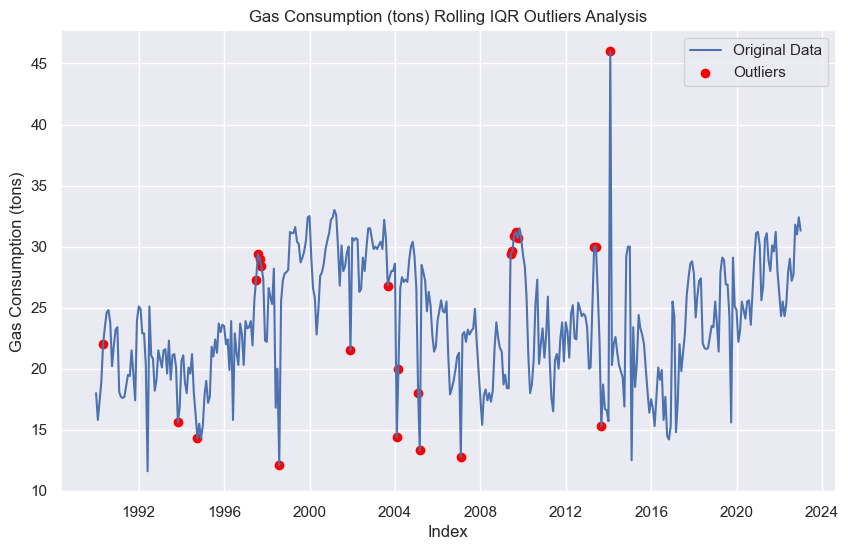

In [540]:
time_series = df['Gas Consumption (tons)']
outliers = detect_rolling_outliers_iqr(time_series)


outlier_values = time_series[outliers]
outliers_df = pd.DataFrame({'Outlier Values': outlier_values})


plot_time_series_with_outliers(time_series, outliers, 'Gas Consumption (tons)')


> As we can see there are a few outliers aside from the obvious extreme values i will decide what to do with these later on

---

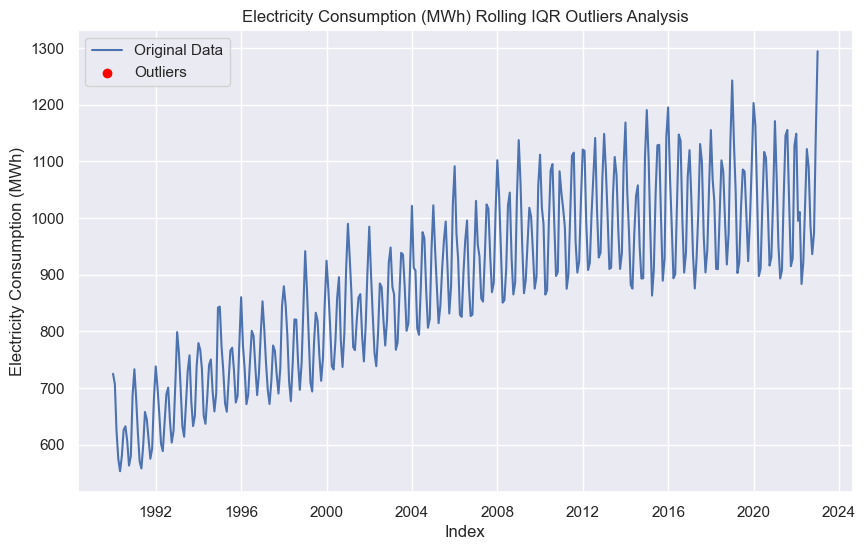

In [618]:
time_series = df['Electricity Consumption (MWh)']
outliers = detect_rolling_outliers_iqr(time_series)

outlier_values = time_series[outliers]
outliers_df = pd.DataFrame({'Outlier Values': outlier_values})


plot_time_series_with_outliers(time_series, outliers, 'Electricity Consumption (MWh)')


>Surprisingly there are no ouliers probably because this trend is addivtive one and the magnitude rougly stays the same

---

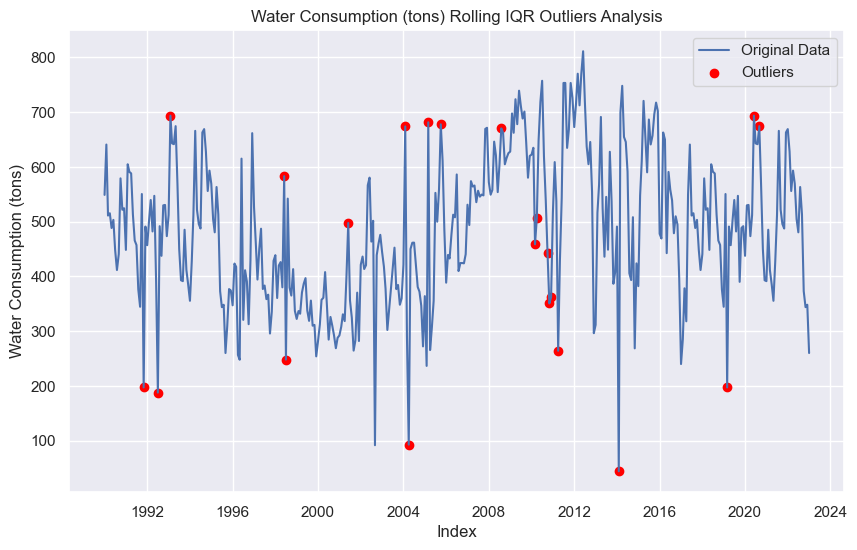

In [543]:
time_series = df['Water Consumption (tons)']
outliers = detect_rolling_outliers_iqr(time_series)

outlier_values = time_series[outliers]
outliers_df = pd.DataFrame({'Outlier Values': outlier_values})

plot_time_series_with_outliers(time_series, outliers, 'Water Consumption (tons)')


> Similarly to Gas consumption there are a few outliers however since from the graph these outliers were not as obvious as the gas consumption it is a good finding

---

## Handling Outliers


##### For all the features i decided to leave the outliers in, in hopes that the model can learn from it and predict these anomalies better in the future even if not perfectly forecasted the models will pick up on certain patterns that happen before anomalies and predict it to a better standard 

---

## **Autocorrelation Analysis**


### *Autocorrelation Function (ACF)*
- The ACF plot helps identify the order of the MA (Moving Average) term in the ARIMA model. 

- (If the ACF values decrease rapidly after a certain lag, it suggests that the MA term should be included in the model.)

- If the ACF values decrease slowly, it suggests the presence of an underlying seasonality and there might be no correlation between each lags, which can be captured by the MA term.

### *Partial Autocorrelation Function (PACF)*

- Significant spikes in the PACF plot indicate a direct relationship with the corresponding lag.  

- The PACF plot is used to identify the order of the AR (Auto Regressive) term in the ARIMA model.  

- If the PACF values drop off after a certain lag, it suggests that the AR term should be included in the model.


- PACF tells direct correlation while ACF tells direct + indirect correlation

For both ACF and PACF plots if there is a spike at a lower value it shows a short term dependency while a spike at a higher value shows a long term dependency


In [545]:
def autocorrelation_plot(data, lags):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Plot ACF
    plot_acf(data, lags=lags, ax=axes[0])
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Autocorrelation Plot')

    # Plot PACF
    plot_pacf(data, lags=lags, ax=axes[1])
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('Partial Autocorrelation')
    axes[1].set_title('Partial Autocorrelation Plot')

    plt.tight_layout()
    plt.show()




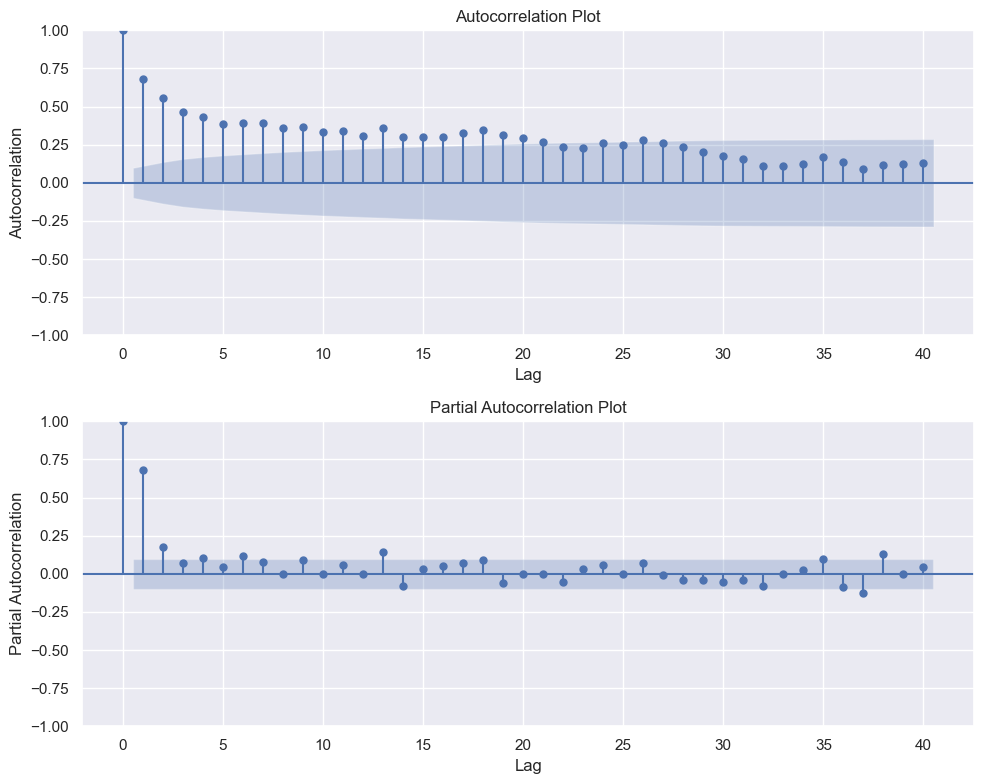

In [546]:
autocorrelation_plot(df['Gas Consumption (tons)'], lags=40)

ACF

start with 0 and during test choose any number above the significance level

PACF

After lag 1 is significantly drops off and stay relatively constantly, hence we can start of with 1 and during tuning maybe 0 can be considered the points after that might not be significant

|              | p (PACF) | d (stationarity) | q (ACF) |
| :----------- | :---------- | :---------- | :---------- |
| **Baseline** | 1           | 0           | 0          |
| **Possible Values** | 0, 1 | 0  | 0 - 10  |


|              | P (PACF) | D (Seasonality) | Q (ACF) |
| :----------- | :---------- | :---------- | :---------- |
| **Baseline** | 1           | 1           | 1          |
| **Possible Values** | 1, 2 | 1 - 3  | 1 - 3  |

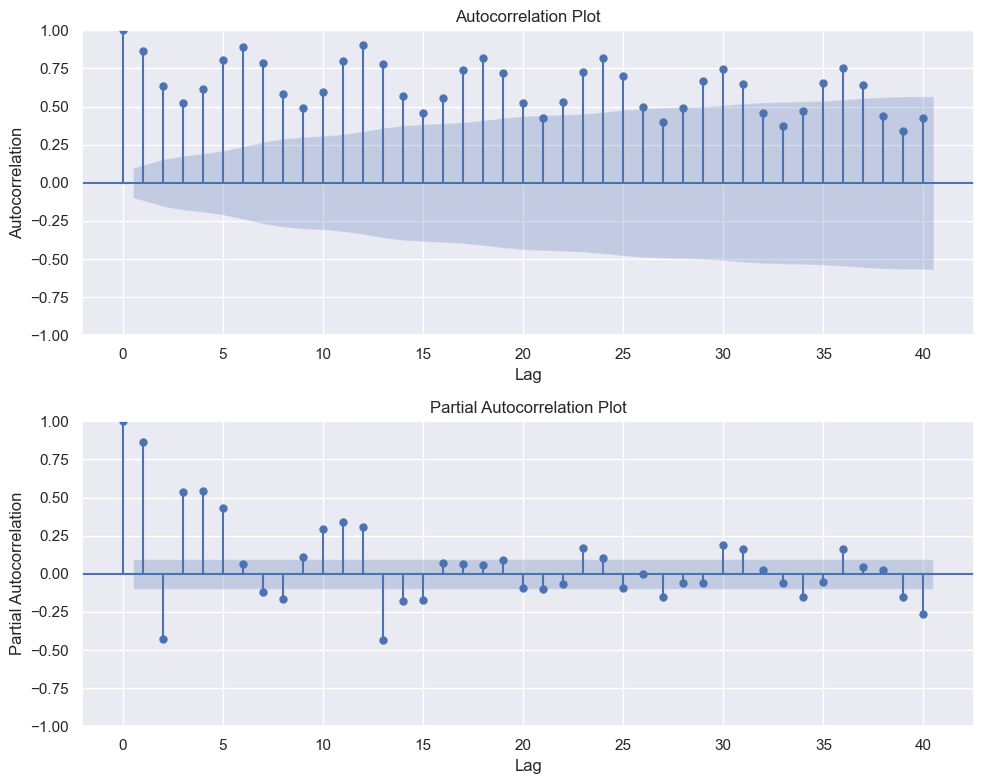

In [547]:
autocorrelation_plot(df['Electricity Consumption (MWh)'], lags=40)




ACF:

this acf plot shows sign of a damped oscillation which shows there shouldn't be a long term dependency in this feature which makes me think the q value is not likely to be very large
0 start
test till 5 max 


PACF:

since there is a significance drop in the 1st lag, we can say that the AR term is 1

for tuning we could work around that basically 0,1,2




|              | p (PACF) | d (stationarity) | q (ACF) |
| :----------- | :---------- | :---------- | :---------- |
| **Baseline** | 1           | 1           | 0          |
| **Possible Values** | 0 - 5 | 1-3  | all the ones with a spike  |

|              | P (PACF) | D (Seasonality) | Q (ACF) |
| :----------- | :---------- | :---------- | :---------- |
| **Baseline** | 1           | 1           | 1          |
| **Possible Values** | 1, 2 | 1 - 3  | 1 - 3  |

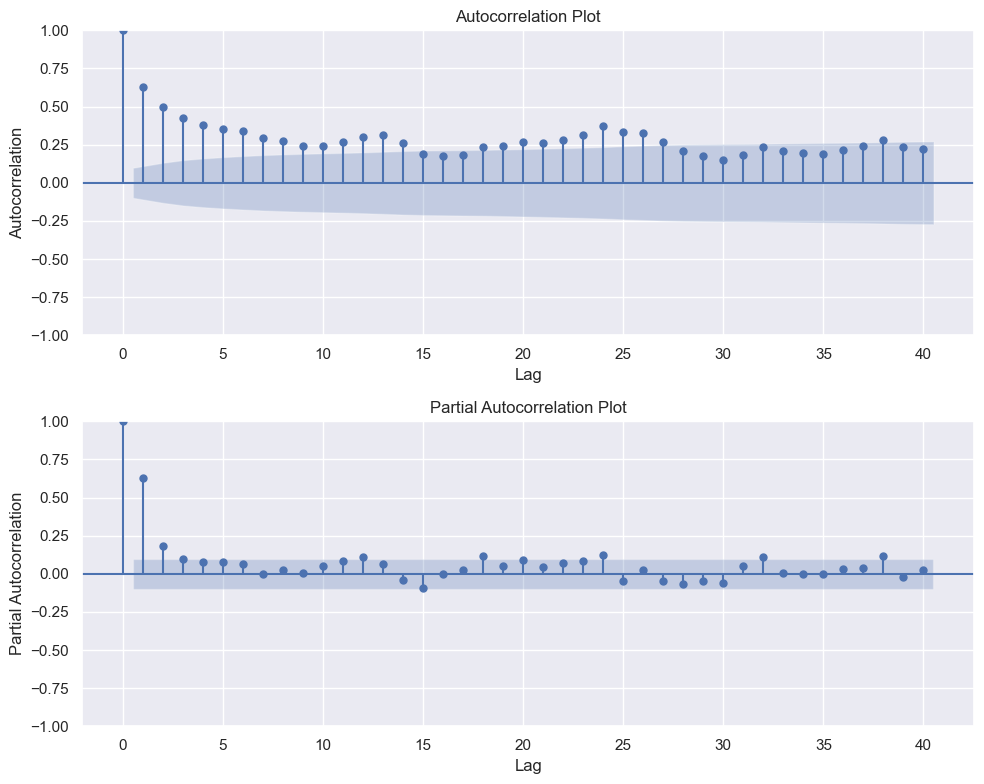

In [548]:
autocorrelation_plot(df['Water Consumption (tons)'], lags=40)

ACF

start with 0 and during test choose any number above the significance level, with the acf plot slowly decrease there might not be a strong correlation between the lags, hence q will be small


PACF

Similar to Gas consumption, the PACF plot shows a significant drop after the 1st lag, hence we can say that the AR term is 1 and for tuning we could work around that basically 0,1 anything after that shouldn't be too significant

|ARIMA         | p (PACF) | d (stationarity) | q (ACF) |
| :----------- | :---------- | :---------- | :---------- |
| **Baseline** | 1           | 1           | 0          |
| **Possible Values** | 0, 1 | 1 - 3  | 0 - 10  |




|SARIMA        | P (PACF) | D (Seasonality) | Q (ACF) |
| :----------- | :---------- | :---------- | :---------- |
| **Baseline** | 0           | 1           | 0          |
| **Possible Values** | 0, 1 | 1 - 3  | 0 - 3  |
---



# SARIMA (Seasonal Order)

for SARIMA seasonal order, the way i choose the parameter is quite similar to normal order but instead in terms of each season, so the reasoning should be around there same, only differnce being D were we don't think of at as for stationarity instead for seasonality so anything feature that has seasonality should be D > 1

---

# Model Selection

based on the analysis we did above, we can start model selection for our forecasting, we will be using the following models:

- ARIMA
- SARIMA
- Holt-Winters Exponential Smoothing

Before we start lets talk about

## Evaluation Method

in supervised learning, we can always using CV (cross validation) where the data is split into training and testing set, and the dataset is always randomized to ensure consistence. However for Time series we can't do that because when we split 80 20 there is no way to randomize the data. So how do we solve this issue 

# Dynamic Expanding Window

similiar to the way i detect outliers, the difference between these 2 is that for expanding window it takes the starting window size, and train it, then forecasting the next few values lets say 3 and comparing it to the real data returning the score, next it takes all the point starting window + the actual values of the 3 datapoints it predict and its the new train set, and the next 3 points are the new test set, and it keeps doing that until the end of the dataset

I understand when purely reading the explanation it can be quite confusing, so i will show a diagram to help you understand better 

![Dynamic Expanding Window.png](<attachment:Dynamic Expanding Window.png>)
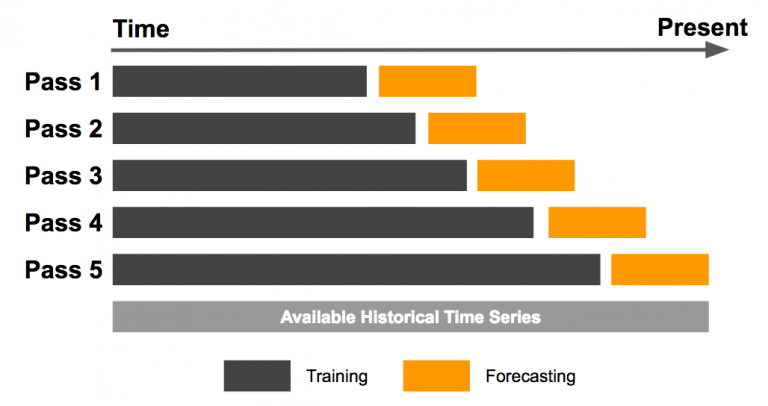

(What Are Pandas “Expanding Window” Functions?, n.d.)

In [549]:
df

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
DATE,,,
1990-01-01,18.0,725.1,548.8
1990-02-01,15.8,706.7,640.7
1990-03-01,17.3,624.5,511.1
1990-04-01,18.9,574.7,515.3
1990-05-01,22.0,553.2,488.4
...,...,...,...
2022-09-01,27.7,986.2,513.3
2022-10-01,31.8,936.1,373.1
2022-11-01,31.0,973.4,343.9


ARIMA MODELS

Parameters needed for arima [p,d,q]

based on the analysis on the acf and pacf plots i did i found the parameters for the ARIMA baseline model to be 


PARAMETER `(Gas Consumption)` = `[1, 0, 0]`

PARAMETER `(Electricity Consumption)` = `[1, 1, 0]`

PARAMETER `(Water Consumption)` = `[1, 1, 0]`

In [670]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error


# Multi step forecasting through the use of expanding window (dynamic expanding window)

def rolling_forecast(df, target_column, initial_window_size, num_steps, order, seasonal_order=None):
    predictions = []
    aic_scores  = []
    mae_scores = []

    window_size = initial_window_size
    for i in range(initial_window_size, len(df), num_steps):
        
        # Get the current window of data
        train = df[target_column].iloc[i - window_size:i]
        test = df[target_column].iloc[i:i + num_steps]
        # print(len(train))
        
        if seasonal_order == None:
            model = ARIMA(train, order=order)

        elif seasonal_order != None:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order)

        
        model_fit = model.fit()


        # Make predictions for the desired number of time steps
        forecast = model_fit.forecast(steps=num_steps)

        predictions.extend(forecast)

        if len(test) == len(forecast):
            mae = mean_absolute_error(test, forecast)
            aic = model_fit.aic

            aic_scores.append(aic)

            mae_scores.append(mae)

        # Update the window size for the next iteration
        window_size += num_steps

    predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
    scores_df = pd.DataFrame({'AIC': aic_scores, 'MAE': mae_scores})
    scores_df.index = [f"Iteration {i+1}" for i in range(len(scores_df))]

    average_aic = scores_df['AIC'].mean()
    average_mae = scores_df['MAE'].mean()

    return predictions_df, scores_df, average_aic, average_mae




def generate_dates(start_date, num_iterations):
    
    dates = []

    # Loop to generate new dates
    current_date = start_date
    for _ in range(num_iterations):
        # Add one month to the current date
        # current_date += datetime.timedelta(days=30)
        current_date += relativedelta(months=1)
        
        dates.append(current_date)

    
    df = pd.DataFrame({'Date': dates})


    df['Date'] = pd.to_datetime(df['Date'])

    return df


analysis1 = pd.DataFrame(columns=['Feature', 'Average AIC', 'Average MAE'])
analysis2 = pd.DataFrame(columns=['Feature', 'Average AIC', 'Average MAE'])


## **Gas consumption**

In [671]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, 'Gas Consumption (tons)', 24, 6, (1, 0, 0))

display(predictions_df)
display(scores_df)
print("Average AIC:", average_aic)
print("Average MAE:", average_mae)

analysis2 = analysis2.append({'Feature': 'Gas Consumption (tons)', 'Average AIC': average_aic, 'Average MAE': average_mae}, ignore_index=True)


,Prediction
0,22.589275
1,21.772098
2,21.262626
3,20.944993
4,20.746964
...,...
373,27.790202
374,26.515456
375,25.646080
376,25.053166


,AIC,MAE
Iteration 1,110.614011,3.116912
Iteration 2,147.749748,3.775354
Iteration 3,183.696741,0.881024
Iteration 4,207.941150,2.055542
Iteration 5,235.313631,1.227301
...,...,...
Iteration 58,1994.719023,3.274121
Iteration 59,2024.455446,3.511226
Iteration 60,2054.781023,3.433977
Iteration 61,2083.495522,1.228558


Average AIC: 1085.2625768556886
Average MAE: 3.4604198776585435


In [620]:
start_date = datetime.date(1992, 1, 1)
num_iterations = len(predictions_df)

result = generate_dates(start_date, num_iterations)
display(result.dtypes)
display(result)

Date    datetime64[ns]
dtype: object

,Date
0,1992-02-01
1,1992-03-01
2,1992-04-01
3,1992-05-01
4,1992-06-01
...,...
373,2023-03-01
374,2023-04-01
375,2023-05-01
376,2023-06-01


> Create a data index for the predictions as well

In [621]:
# set the dates i created as the index
predictions = predictions_df.set_index(result['Date'])

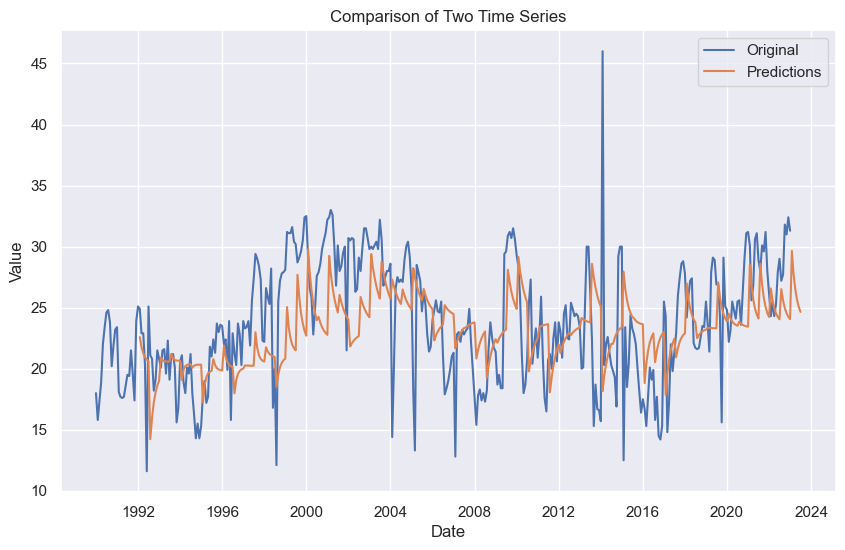

In [622]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Gas Consumption (tons)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

> From the plotted out graph we can see that arima does not perform extremely well but still not the worse, with an average AIC score of 1000 it ain't the worse however there is room for improvement

---

Electricity Consumption

In [672]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, 'Electricity Consumption (MWh)', 24, 6, (1, 1, 0))

display(predictions_df)
display(scores_df)
print("Average AIC:", average_aic)
print("Average MAE:", average_mae)
analysis2 = analysis2.append({'Feature': 'Electricity Consumption (MWh)', 'Average AIC': average_aic, 'Average MAE': average_mae}, ignore_index=True)


,Prediction
0,722.501684
1,741.698825
2,750.665129
3,754.852973
4,756.808966
...,...
373,1235.637968
374,1244.521606
375,1247.818497
376,1249.042037


,AIC,MAE
Iteration 1,242.783626,98.591125
Iteration 2,304.089568,41.098607
Iteration 3,366.607249,87.409987
Iteration 4,432.140963,48.455645
Iteration 5,497.609700,91.460498
...,...,...
Iteration 58,4138.311031,91.621366
Iteration 59,4206.032601,116.392767
Iteration 60,4279.877064,98.863044
Iteration 61,4355.211975,242.063972


Average AIC: 2287.498335528306
Average MAE: 106.66170740537194


In [633]:
predictions = predictions_df.set_index(result['Date'])

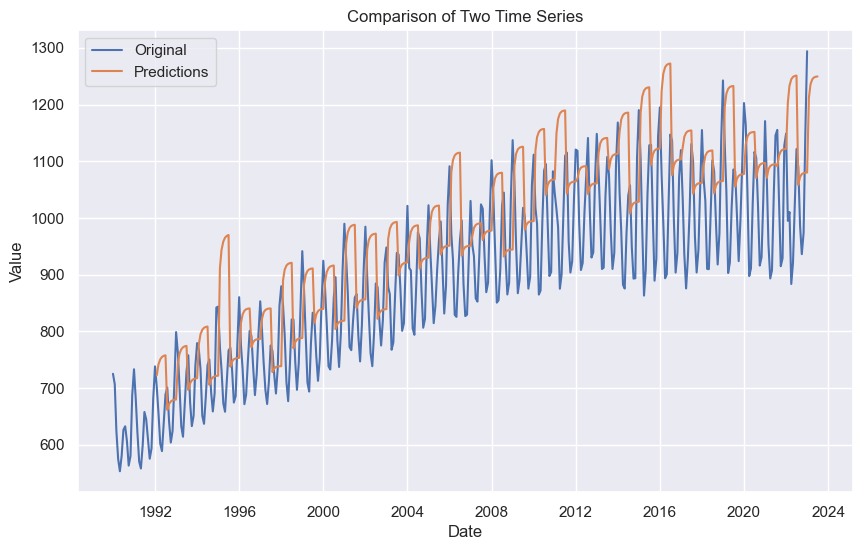

In [634]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Electricity Consumption (MWh)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

> On the other hand ARIMA did terribily for this feature with an average AIC score of 2000, just by visual inspection we can see the model does not forecast it accurately, maybe after differencing the model cannot capture the patterns as well

---

#### Water Consumption

In [746]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, 'Water Consumption (tons)', 24, 6, (1, 1, 0))

display(predictions_df)
display(scores_df)
print("Average AIC:", average_aic)
print("Average MAE:", average_mae)
analysis2 = analysis2.append({'Feature': 'Water Consumption (tons)', 'Average AIC': average_aic, 'Average MAE': average_mae}, ignore_index=True)


,Prediction
0,272.146769
1,435.282793
2,313.679094
3,404.324062
4,336.756132
...,...
373,347.322302
374,347.159418
375,347.213704
376,347.195611


,AIC,MAE
Iteration 1,277.410567,128.014835
Iteration 2,348.265280,97.067977
Iteration 3,429.360200,128.023038
Iteration 4,500.914243,186.619358
Iteration 5,572.770526,116.277135
...,...,...
Iteration 58,4475.295407,96.892045
Iteration 59,4546.399471,33.084792
Iteration 60,4615.384298,149.012317
Iteration 61,4690.202114,53.210069


Average AIC: 2511.2969437092693
Average MAE: 110.75737845388718


In [747]:
start_date = datetime.date(1992, 1, 1)
num_iterations = len(predictions_df)

result = generate_dates(start_date, num_iterations)
display(result.dtypes)
display(result)

Date    datetime64[ns]
dtype: object

,Date
0,1992-02-01
1,1992-03-01
2,1992-04-01
3,1992-05-01
4,1992-06-01
...,...
373,2023-03-01
374,2023-04-01
375,2023-05-01
376,2023-06-01


In [748]:
predictions = predictions_df.set_index(result['Date'])

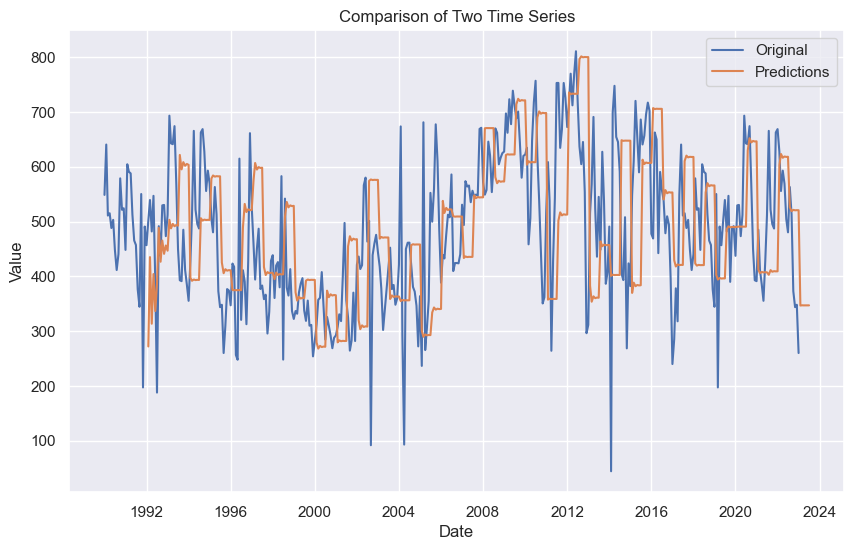

In [749]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Water Consumption (tons)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

> Water consumption also isn't the best, maybe its the incorrect baseline parameter, maybe its just ARIMA not being suited for this dataset, we won't know unless we perform further testing


In [674]:
analysis2

,Feature,Average AIC,Average MAE
0,Gas Consumption (tons),1085.262577,3.460420
1,Electricity Consumption (MWh),2287.498336,106.661707
2,Water Consumption (tons),2511.296944,110.757378


---

# SARIMA Models

SARIMA model (Seasonal ARIMA) is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. Where its similar to ARIMA in the way the concept behind the model goes, however the key difference is that SARIMA is better at identifying features with a seasonal component to them

SARIMA models are slightly different in the sense that they have a seasonal component to them, so there is a seasonal order seperate from the normal order

with parameters (P,D,Q,s)

where 
P = seasonal order of the autoregressive part  

D = seasonal order of the differencing part  
(if there is seasonality in the data, then D > 0)  

Q = seasonal order of the moving average part  

s = number of time steps for a single seasonal period (12)  


Parameters uniquely needed for SARIMA [P,D,Q,s]

PARAMETER `(Gas Consumption)` = `[1, 1 ,1, 12]`

PARAMETER `(Electricity Consumption)` = `[1, 1, 1, 12]`

PARAMETER `(Water Consumption)` = `[0, 1, 0, 12]`

## **Gas Consumption**

In [751]:


predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, 'Gas Consumption (tons)', 24, 6, (1, 0 , 0), seasonal_order=(1, 1, 1, 12))


display(predictions_df)

display(scores_df)

print("Average AIC:", average_aic)
print("Average MAE:", average_mae)
analysis1 = analysis1.append({'Feature': 'Gas Consumption (tons)', 'Average AIC': average_aic, 'Average MAE': average_mae}, ignore_index=True)


,Prediction
0,24.672352
1,18.545304
2,17.646533
3,17.088572
4,16.335230
...,...
373,27.574416
374,25.486564
375,25.587791
376,25.320184


,AIC,MAE
Iteration 1,64.922821,4.552903
Iteration 2,102.066802,3.756034
Iteration 3,137.150799,2.751975
Iteration 4,166.929514,3.138451
Iteration 5,198.184878,1.216891
...,...,...
Iteration 58,1974.680090,3.110906
Iteration 59,2004.504139,3.531541
Iteration 60,2034.393921,3.385327
Iteration 61,2062.912469,1.539277


Average AIC: 1054.7519484753636
Average MAE: 3.50475972392916


In [640]:
predictions = predictions_df.set_index(result['Date'])
print(predictions)

            Prediction
Date                  
1992-02-01   24.672352
1992-03-01   18.545304
1992-04-01   17.646533
1992-05-01   17.088572
1992-06-01   16.335230
...                ...
2023-03-01   27.574416
2023-04-01   25.486564
2023-05-01   25.587791
2023-06-01   25.320184
2023-07-01   24.350107

[378 rows x 1 columns]


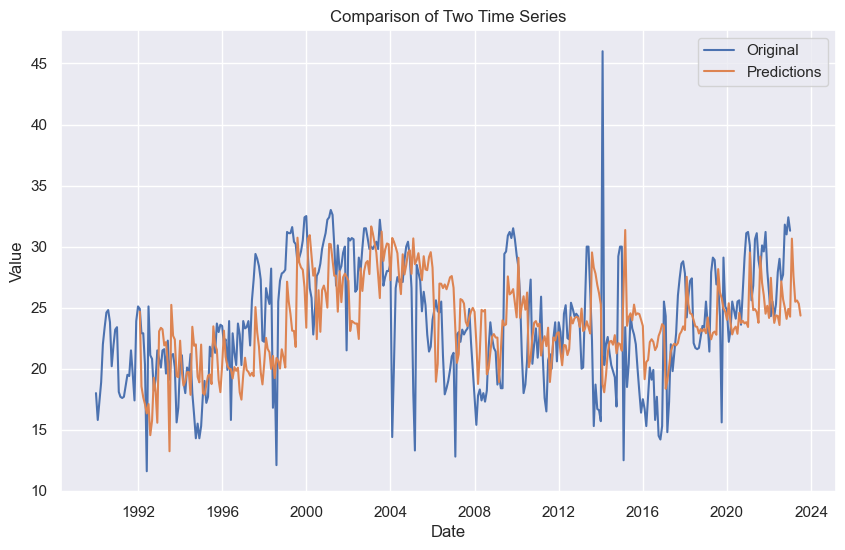

In [641]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Gas Consumption (tons)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

> The prediction for gas consumption is better using SARIMA compared to ARIMA although the AIC score is quite similar the prediction is much better in the case of SARIMA

---

## **electricity consumption**

In [752]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, 'Electricity Consumption (MWh)', 24, 6, (1, 1 , 0), seasonal_order=(1, 1, 1, 12))


# # Print the predictions DataFrame
display(predictions_df)

# # Print the scores DataFrame
display(scores_df)

# # Print the average MAPE and MAE scores
print("Average AIC:", average_aic)
print("Average MAE:", average_mae)
analysis1 = analysis1.append({'Feature': 'Electricity Consumption (MWh)', 'Average AIC': average_aic, 'Average MAE': average_mae}, ignore_index=True)


,Prediction
0,749.361755
1,661.615916
2,628.227973
3,574.232650
4,571.258143
...,...
373,1113.226329
374,1052.756806
375,941.981529
376,964.013271


,AIC,MAE
Iteration 1,99.217493,22.747906
Iteration 2,147.141575,10.444007
Iteration 3,194.630423,19.057505
Iteration 4,247.411034,8.331469
Iteration 5,294.526537,18.381302
...,...,...
Iteration 58,3287.573726,24.561667
Iteration 59,3343.063945,41.729010
Iteration 60,3404.098739,26.515453
Iteration 61,3466.243809,61.325536


Average AIC: 1768.0548705589993
Average MAE: 26.33220519172417


In [643]:
predictions = predictions_df.set_index(result['Date'])

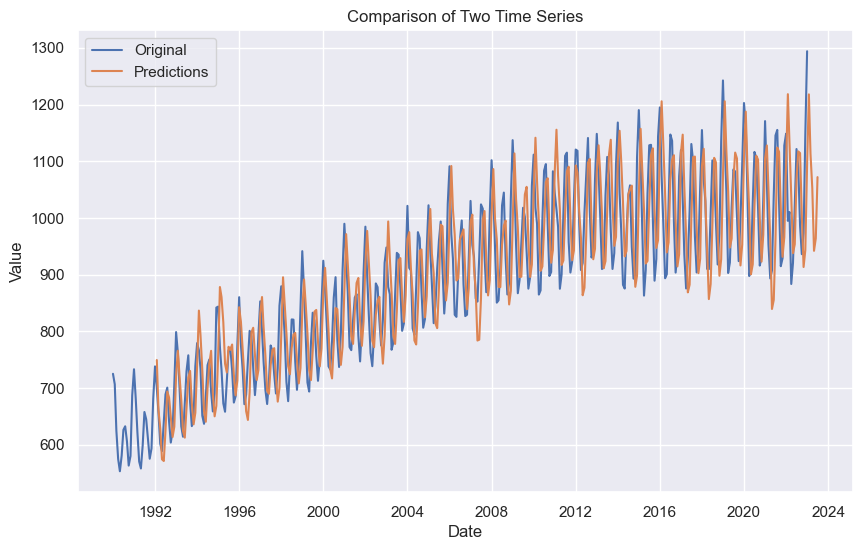

In [644]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Electricity Consumption (MWh)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

> For electricity the difference is night and day, the SARIMA is able to properly predict dispite the trend and provided a much better prediction compared to ARIMA probably due to the fact it took seasonality into account

---


## **water consumption**

In [753]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, 'Water Consumption (tons)', 24, 6, (0, 1 , 0), seasonal_order=(1, 1, 1, 12))


display(predictions_df)

display(scores_df)

print("Average AIC:", average_aic)
print("Average MAE:", average_mae)
analysis1 = analysis1.append({'Feature': 'Water Consumption (tons)', 'Average AIC': average_aic, 'Average MAE': average_mae}, ignore_index=True)


,Prediction
0,410.998217
1,586.878274
2,608.274268
3,603.092163
4,513.488024
...,...
373,372.639448
374,378.848377
375,383.068047
376,387.046896


,AIC,MAE
Iteration 1,145.545481,68.609140
Iteration 2,217.973179,158.103830
Iteration 3,301.945725,158.749246
Iteration 4,371.754354,110.395428
Iteration 5,443.315814,109.088498
...,...,...
Iteration 58,4414.250369,87.642473
Iteration 59,4484.645457,58.766742
Iteration 60,4554.107490,192.988624
Iteration 61,4629.303070,126.343895


Average AIC: 2418.5629465499583
Average MAE: 114.83285431315599


In [646]:
predictions = predictions_df.set_index(result['Date'])

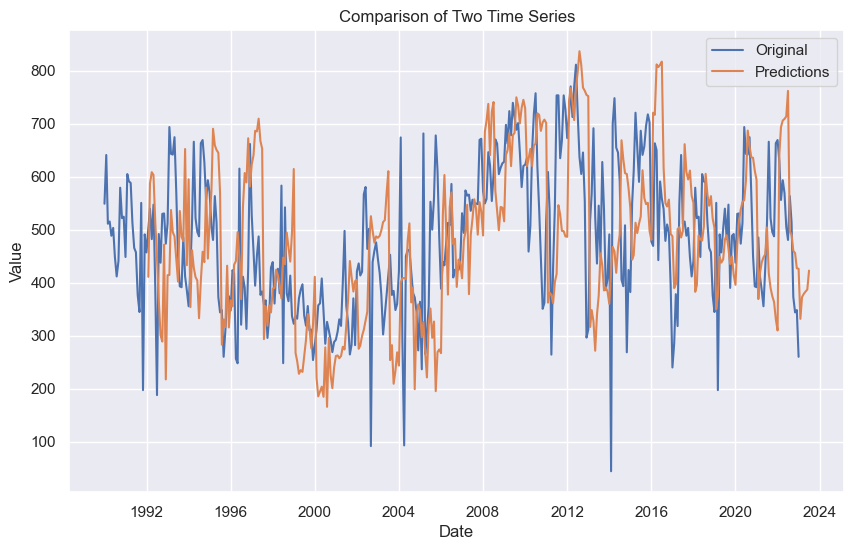

In [647]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Water Consumption (tons)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

> For this visual inspection is quite hard to tell how well the model performed but i can tell it isn't terrible the AIC score is slightly better compared to ARIMA but we will really compare at the end of baseline testing

In [754]:
# Average AIC and MAE for each feature
analysis1

,Feature,Average AIC,Average MAE
0,Gas Consumption (tons),1054.751948,3.504760
1,Electricity Consumption (MWh),1768.054871,26.332205
2,Water Consumption (tons),2418.562947,114.832854


> we can see for all feature SARIMA does a better job at predicting compared to ARIMA so unless the parameters are very wrong SARIMA looks like a clear choice compared to ARIMA

---

## **Holt-Winters Exponential Smoothing**


There are now new parameters for this new model, the parameters are as follows:

alpha: smoothing level controls how much the recent observations influence the forecasts,higher values gives more weight to the recent observations


beta: smoothing slope makes the model adapt to trend better, high values makes the trend adapt faster to recent fluctuations


gamma: damping slope stabilizes the seasonal indices, preventing extreme fluctuations in the seasonal indices

<u>Trend </u> / <u> Seasonality </u> : <u> additive </u> or <u> multiplicative </u>

- Additive Trend 
    - Trend that adds a constant value to data.

-  Multiplicative Trend
    - Trend that multiplies data by a constant value.

- Additive Seasonality
    - Seasonal patterns that adds a constant value to data.

- Multiplicative Seasonality
    - Seasonal patterns that multiplies data by a constant value.

for more information refer to the reference below (Paramita, 2020)

In [582]:

# def rolling_forecast_smoothing(df, target_column, initial_window_size, num_steps, smoothing_level, smoothing_slope=None, damping_slope=None, seasonal_periods=None):
#     predictions = []
#     aic_scores = []
#     mae_scores = []

#     window_size = initial_window_size
#     for i in range(initial_window_size, len(df), num_steps):
#         # Get the current window of data
#         train = df[target_column].iloc[i - window_size:i]
#         test = df[target_column].iloc[i:i + num_steps]

#         model = ExponentialSmoothing(train, seasonal_periods=seasonal_periods, trend="additive", seasonal="additive")

#         model_fit = model.fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, damping_slope=damping_slope)

#         # Make predictions for the desired number of time steps
#         forecast = model_fit.forecast(steps=num_steps)

#         predictions.extend(forecast)

#         if len(test) == len(forecast):
#             aic = model_fit.aic
#             mae = mean_absolute_error(test, forecast)

#             aic_scores.append(aic)
#             mae_scores.append(mae)

#         # Update the window size for the next iteration
#         window_size += num_steps

#     predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
#     scores_df = pd.DataFrame({'AIC': aic_scores, 'MAE': mae_scores})
#     scores_df.index = [f"Iteration {i+1}" for i in range(len(scores_df))]

#     average_aic = scores_df['AIC'].mean()
#     average_mae = scores_df['MAE'].mean()

#     return predictions_df, scores_df, average_aic, average_mae

In [649]:
def rolling_forecast_smoothing(df, target_column, initial_window_size, num_steps, smoothing_level, smoothing_slope=None, damping_slope=None, seasonal_periods=None, trend="additive", seasonal="additive"):
    predictions = []
    aic_scores = []
    mae_scores = []

    window_size = initial_window_size
    for i in range(initial_window_size, len(df), num_steps):
        # Get the current window of data
        train = df[target_column].iloc[i - window_size:i]
        test = df[target_column].iloc[i:i + num_steps]

        model = ExponentialSmoothing(train, seasonal_periods=seasonal_periods, trend=trend, seasonal=seasonal)

        
        model_fit = model.fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, damping_slope=damping_slope)

        # Make predictions for the desired number of time steps
        forecast = model_fit.forecast(steps=num_steps)

        predictions.extend(forecast)

        if len(test) == len(forecast):
            aic = model_fit.aic
            mae = mean_absolute_error(test, forecast)

            aic_scores.append(aic)
            mae_scores.append(mae)

        # Update the window size for the next iteration
        window_size += num_steps
    predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
    scores_df = pd.DataFrame({'AIC': aic_scores, 'MAE': mae_scores})
    scores_df.index = [f"Iteration {i+1}" for i in range(len(scores_df))]

    average_mape = scores_df['AIC'].mean()
    average_mae = scores_df['MAE'].mean()

    return predictions_df, scores_df, average_mape, average_mae

## **Gas Consumption**

trend = <u> additive</u> / multiplicative

seasonal = <u> additive</u> / multiplicative

In [755]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast_smoothing(df, 'Gas Consumption (tons)', 24, 6, 0.2, 0.1, 0.9, 12)

display(predictions_df)


display(scores_df)

print("Average AIC:", average_aic)
print("Average MAE:", average_mae)

,Prediction
0,18.123096
1,14.294111
2,14.770959
3,15.453631
4,16.992058
...,...
373,29.167657
374,28.753388
375,29.677342
376,30.099995


,AIC,MAE
Iteration 1,58.672358,7.158739
Iteration 2,98.030226,1.805657
Iteration 3,106.585090,2.237173
Iteration 4,116.197251,3.454967
Iteration 5,129.070258,1.777784
...,...,...
Iteration 58,1032.243473,2.641921
Iteration 59,1045.776958,2.464842
Iteration 60,1058.446307,1.629315
Iteration 61,1069.597424,5.061866


Average AIC: 556.1003845071921
Average MAE: 3.6159451945415886


In [756]:
predictions = predictions_df.set_index(result['Date'])

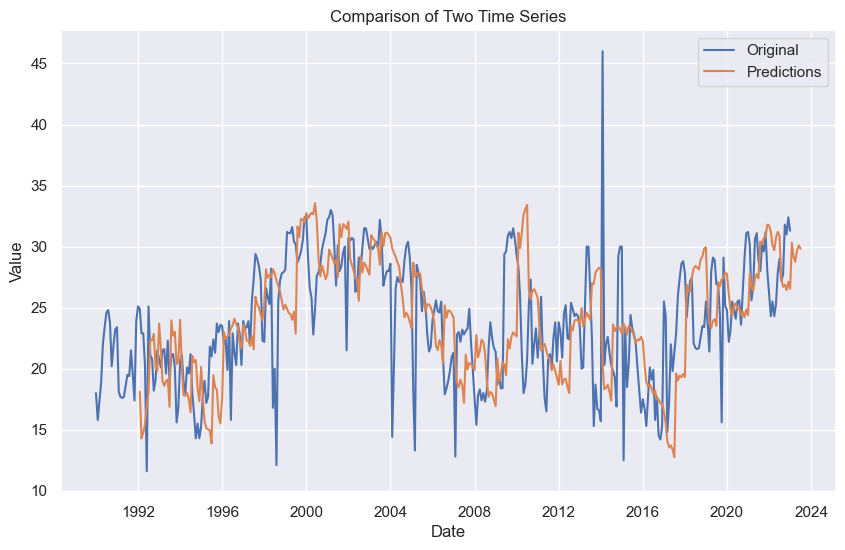

In [757]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Gas Consumption (tons)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

> Looking at the graph only it is quite comparable to SARIMA, however the AIC score for SARIMA is higher compared to exponential smoothing, lets see if this lead is maintained after tuning

---

## **electricity Consumption**

trend = <u> additive</u> / multiplicative

seasonal = <u> additive</u> / multiplicative

In [653]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast_smoothing(df, 'Electricity Consumption (MWh)', 24, 6, 0.2, 0.1, 0.9, 12)

display(predictions_df)


display(scores_df)

print("Average AIC:", average_aic)
print("Average MAE:", average_mae)

,Prediction
0,737.830931
1,702.273786
2,632.549466
3,581.907896
4,565.249287
...,...
373,1088.246404
374,1023.725854
375,917.059550
376,940.481947


,AIC,MAE
Iteration 1,129.267377,17.985447
Iteration 2,166.235699,13.458802
Iteration 3,199.950400,15.243288
Iteration 4,231.201058,16.602558
Iteration 5,269.826211,19.175772
...,...,...
Iteration 58,2408.054533,31.807449
Iteration 59,2452.093631,25.473744
Iteration 60,2493.649203,44.292028
Iteration 61,2541.848859,41.329795


Average AIC: 1309.8457511539536
Average MAE: 24.332653483729782


In [654]:
predictions = predictions_df.set_index(result['Date'])

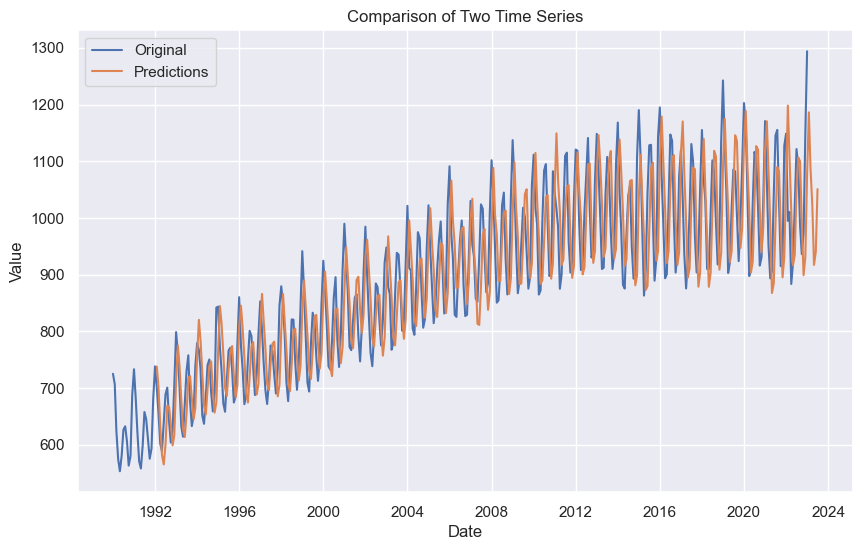

In [655]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Electricity Consumption (MWh)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

> The difference for electricity consumption is even harder to tell based on a visual standpoint, however the Average AIC is night and day with exponential smoothing being around 300 AIC values less, of course AIC doesn't directly tell you that the model is better, but it is a good indicator as it tells the fit of the model

---

### **Water Consumption**

trend = <u> additive</u> / multiplicative

seasonal = <u> additive</u> / multiplicative

In [656]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast_smoothing(df, 'Water Consumption (tons)', 24, 6, 0.2, 0.1, 0.9, 12)

display(predictions_df)


display(scores_df)

print("Average AIC:", average_aic)
print("Average MAE:", average_mae)

,Prediction
0,422.570434
1,543.563171
2,468.878708
3,466.697745
4,413.102431
...,...
373,415.170694
374,403.377956
375,419.077612
376,408.912254


,AIC,MAE
Iteration 1,223.889504,50.093882
Iteration 2,271.593252,127.255685
Iteration 3,339.942607,110.227100
Iteration 4,390.412748,146.909854
Iteration 5,446.837250,93.077258
...,...,...
Iteration 58,3489.803335,73.756183
Iteration 59,3542.710915,164.816802
Iteration 60,3598.712708,172.395634
Iteration 61,3663.017339,96.836198


Average AIC: 1963.583471468869
Average MAE: 109.5023234784005


In [657]:
predictions = predictions_df.set_index(result['Date'])

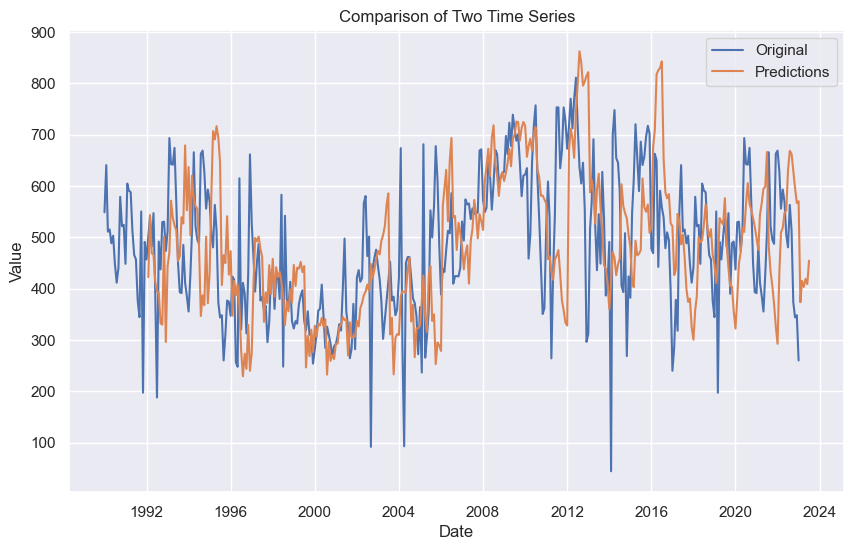

In [658]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Water Consumption (tons)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

> For Water consumption due to the complexity of the time series data, it is hard for any model to perform exceptionally well however with that being said exponential smoothing based on baseline testing has performed the best with the lowest AIC value, we will take this into consideration when we tune the parameters

---

## Prophet (extra) i can't do it

Although i find it hard evaluating a prophet model on a dynamic expanding window basis, i can only theories that Prophet should be a good model for this dataset, due to Prophets ability to distinguish between the trends and seasonality, it will be good for all the features since seasonality is present is all features

In [593]:
# import pandas as pd
# from sklearn.metrics import mean_absolute_error

# def rolling_forecast_prophet(df, target_column, initial_window_size, num_steps):
#     predictions = []
#     aic_scores = []
#     mae_scores = []

#     window_size = initial_window_size
#     for i in range(initial_window_size, len(df), num_steps):
#         # Get the current window of data
#         train = df.iloc[:i]

#         train_prophet = train.rename(columns={target_column: 'y'})
#         train_prophet['ds'] = train_prophet.index

#         model = Prophet()

#         model.fit(train_prophet)

#         if i + num_steps < len(train_prophet):
#             num_steps_iter = num_steps
#         else:
#             num_steps_iter = len(df) - i

#         # Make predictions for the desired number of time steps
#         future_dates = pd.date_range(start=train.index[-1], periods=num_steps_iter + 1, closed='right')
#         future_dates = future_dates[1:]  # Exclude the last date of the training data
#         future_df = pd.DataFrame({'ds': future_dates})
#         forecast = model.predict(future_df)['yhat'].values

#         predictions.extend(forecast)

#         if len(train) >= window_size:
#             # aic_scores.append(model.aic)
#             mae = mean_absolute_error(df[target_column].iloc[i:i + num_steps], forecast)
#             mae_scores.append(mae)

#     predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
#     scores_df = pd.DataFrame({'MAE': mae_scores})
#     scores_df.index = [f"Iteration {i+1}" for i in range(len(scores_df))]

#     # average_aic = scores_df['AIC'].mean()
#     average_mae = scores_df['MAE'].mean()

#     return predictions_df, scores_df, average_aic, average_mae

In [594]:
# target_column = 'Gas Consumption (tons)'
# initial_window_size = 24 
# num_steps = 3 

# # Apply the rolling_forecast_prophet function
# predictions_df, scores_df, average_mae = rolling_forecast_prophet(df, target_column, initial_window_size, num_steps)

# print(predictions_df)

# print(scores_df)

# print("Average AIC:", average_aic)
# print("Average MAE:", average_mae)

---

## Hyperparameter tuning

as we can see some models perform better than others, but we can't just finalise the model we want directly from those results, Lets tune each of the parameter so we can get the best each model provides and compare them again for our final model

#### **Warning this part of the code takes extremely long to run, on average 1 hour for each code block, run at your own risk**

Lets see what model we have to tune:

- **`ARIMA`**
    - `Gas Consumption`
    - `Water Consumption`

- **`SARIMA`**
    - `Gas Consumption`
    - `Electricity Consumption`
    - `Water Consumption`  

- **`Holt-Winters`**
    - `Gas Consumption`
    - `Electricity Consumption`
    - `Water Consumption`

In [ ]:
def rolling_forecast(df, target_column, initial_window_size, num_steps, order, seasonal_order=None):
    predictions = []
    aic_scores  = []
    mae_scores = []

    window_size = initial_window_size
    for i in range(initial_window_size, len(df), num_steps):
        
        # Get the current window of data
        train = df[target_column].iloc[i - window_size:i]
        test = df[target_column].iloc[i:i + num_steps]
        # print(len(train))
        
        if seasonal_order == None:
            model = ARIMA(train, order=order)

        elif seasonal_order != None:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order)

        
        model_fit = model.fit()


        # Make predictions for the desired number of time steps
        forecast = model_fit.forecast(steps=num_steps)

        predictions.extend(forecast)

        if len(test) == len(forecast):
            mae = mean_absolute_error(test, forecast)
            aic = model_fit.aic

            aic_scores.append(aic)

            mae_scores.append(mae)

        # Update the window size for the next iteration
        window_size += num_steps

    predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
    scores_df = pd.DataFrame({'AIC': aic_scores, 'MAE': mae_scores})
    scores_df.index = [f"Iteration {i+1}" for i in range(len(scores_df))]

    average_aic = scores_df['AIC'].mean()
    average_mae = scores_df['MAE'].mean()

    return predictions_df, scores_df, average_aic, average_mae

In [691]:
# predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, 'Gas Consumption (tons)', 24, 3, (1, 0, 1))

def hyperparameter_tuning(df, target_variable, initial_window_size, num_steps, p_range, d_range, q_range, P_range=None, D_range=None, Q_range=None, s=12):
    # result = pd.DataFrame(columns=['Model','p', 'd', 'q', 'P', 'D', 'Q', 'AIC', 'MAE'])
    model = ''

    if P_range != None and D_range != None and Q_range != None:
        print('p, d, q, P, D, Q')
        result = pd.DataFrame(columns=['Model', 'p', 'd', 'q', 'P', 'D', 'Q', 'AIC', 'MAE'])

        for P in P_range:
             for D in D_range:
                  for Q in Q_range:
                        try:
                            model = 'SARIMA'
                            predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, target_variable, initial_window_size, num_steps, (q_range, d_range, p_range), seasonal_order=(P, D, Q, s))
                            # print("Average AIC:", average_aic)
                            # print("Average MAE:", average_mae)
                            
                            result = result.append({'Model': model, 'p': p_range, 'd': d_range, 'q': q_range, 'P': P,'D': D, 'Q': Q, 'AIC': round(average_aic,4), 'MAE': round(average_mae,4)}, ignore_index=True)
                            print(p_range, d_range, q_range, P, D, Q)

                        except np.linalg.LinAlgError as e:
                            continue
    elif P_range == None:
        print('p, d , q')
        result = pd.DataFrame(columns=['Model', 'p', 'd', 'q', 'AIC', 'MAE'])
        for p in p_range:
            for d in d_range:
                for q in q_range:
                    try:
                        model = 'ARIMA'
                        predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, target_variable, initial_window_size, num_steps, (q, d, p))
                        # print("Average AIC:", average_aic)
                        # print("Average MAE:", average_mae)
                        result = result.append({'Model': model, 'p': p, 'd': d, 'q': q, 'AIC': average_aic, 'MAE': average_mae }, ignore_index=True)
                        print(f'{p}, {d} , {q}  and the result issss {average_aic}')
                    except np.linalg.LinAlgError as e:
                        continue
    print('hyperparameter Tuning Done')
    return result


## ARIMA Gas Consumption

In [659]:
p_range = range(0, 2)   
d_range = range(0, 1)  
q_range = range(0, 4)   

result = hyperparameter_tuning(df, 'Gas Consumption (tons)', 24, 6, p_range, d_range, q_range)

p, d , q
0, 0 , 0  and the result issss 1233.523445342454
0, 0 , 1  and the result issss 1085.2625768556886
0, 0 , 2  and the result issss 1079.6202637691913
0, 0 , 3  and the result issss 1080.8857163063215
1, 0 , 0  and the result issss 1151.0383776862632
1, 0 , 1  and the result issss 1078.3788880474522
1, 0 , 2  and the result issss 1074.5031242663665
1, 0 , 3  and the result issss 1075.6739397669944
hyperparameter Tuning Done


In [660]:
result.sort_values(by='AIC', ascending=False, inplace=True)
result

,Model,p,d,q,AIC,MAE
0,ARIMA,0,0,0,1233.523445,4.136335
4,ARIMA,1,0,0,1151.038378,3.993915
1,ARIMA,0,0,1,1085.262577,3.460420
3,ARIMA,0,0,3,1080.885716,3.335195
2,ARIMA,0,0,2,1079.620264,3.305689
5,ARIMA,1,0,1,1078.378888,3.259155
7,ARIMA,1,0,3,1075.673940,3.288063
6,ARIMA,1,0,2,1074.503124,3.304983


> Even after tuning ARIMA didn't really improve compare to the baseline, which makes it hard to compare to the other 2 models disqualifying it from the final model for `Gas Consumption`

---

## ARIMA electricity (FOR SARIMA)

In [684]:
p_range = range(0, 6)  
d_range = range(1, 4)   
q_range = range(1, 6)   
# q_range = [6,12,18]


result = hyperparameter_tuning(df, 'Electricity Consumption (MWh)', 24, 6, p_range, d_range, q_range)



p, d , q
0, 1 , 1  and the result issss 2287.498335528306
0, 1 , 2  and the result issss 2165.4586417349065
0, 1 , 3  and the result issss 2091.8171775152905
0, 1 , 4  and the result issss 2060.23716219667
0, 1 , 5  and the result issss 2061.5225660666233
0, 2 , 1  and the result issss 2346.4641739504973
0, 2 , 2  and the result issss 2313.194737876947
0, 2 , 3  and the result issss 2237.929889208497
0, 2 , 4  and the result issss 2147.44516589602
0, 2 , 5  and the result issss 2109.7432848997323
0, 3 , 1  and the result issss 2438.4057073330328
0, 3 , 2  and the result issss 2431.308827428302
0, 3 , 3  and the result issss 2394.270736760059
0, 3 , 4  and the result issss 2304.8528898848754
0, 3 , 5  and the result issss 2241.3584013649993
1, 1 , 1  and the result issss 2251.1152220630333
1, 1 , 2  and the result issss 2072.931190458218
1, 1 , 3  and the result issss 2066.7418136929377
1, 1 , 4  and the result issss 2061.625915796133
1, 1 , 5  and the result issss 2063.3832815203154
1,

In [685]:
result.sort_values(by='AIC', ascending=False, inplace=True)
result

,Model,p,d,q,AIC,MAE
10,ARIMA,0,3,1,2438.405707,1213.631101
11,ARIMA,0,3,2,2431.308827,1061.194341
12,ARIMA,0,3,3,2394.270737,761.365851
5,ARIMA,0,2,1,2346.464174,447.576313
24,ARIMA,1,3,1,2343.147896,466.309588
...,...,...,...,...,...,...
58,ARIMA,4,1,2,1993.062873,32.140576
75,ARIMA,5,1,5,1988.752025,34.476884
77,ARIMA,5,2,2,1987.592588,32.884998
50,ARIMA,3,2,4,1970.165301,81.233115


> for electricity, i tuned it so that the tuning process of SARIMA can be faster, for the parameter with the best result it is clear that it is 2,1,2 with the lowest AIC score out of all the parameters, however when taking a closer look we can see the MAE is extremely high compared to the rest with more than 100x the other results showing clear signs of overfitting,  

>so we will take the second best parameter Which is 3,2,4

---
## ARIMA Water Consumption 

In [676]:
p_range = range(0, 2)  
d_range = range(1, 4)   
q_range = range(0, 5)   
# q_range = [6,12,18]


result = hyperparameter_tuning(df, 'Water Consumption (tons)', 24, 6, p_range, d_range, q_range)

p, d , q
0, 1 , 0  and the result issss 2540.1229553251624
0, 1 , 1  and the result issss 2511.2969437092693
0, 1 , 2  and the result issss 2503.873434684614
0, 1 , 3  and the result issss 2499.967253157246
0, 1 , 4  and the result issss 2497.0167594194018
0, 2 , 0  and the result issss 2734.5785896320285
0, 2 , 1  and the result issss 2637.8234008023255
0, 2 , 2  and the result issss 2597.651044114153
0, 2 , 3  and the result issss 2576.6336674903514
0, 2 , 4  and the result issss 2559.7548686906675
0, 3 , 0  and the result issss 2960.819038164231
0, 3 , 1  and the result issss 2809.872915119876
0, 3 , 2  and the result issss 2734.33118245388
0, 3 , 3  and the result issss 2692.8685280366635
0, 3 , 4  and the result issss 2664.950753386346
1, 1 , 0  and the result issss 2491.799619263168
1, 1 , 1  and the result issss 2483.664784814987
1, 1 , 2  and the result issss 2483.638865614307
1, 1 , 3  and the result issss 2485.4161451603554
1, 2 , 0  and the result issss 2536.00373227277
1, 2

In [677]:
result.sort_values(by='AIC', ascending=False, inplace=True)
result

,Model,p,d,q,AIC,MAE
10,ARIMA,0,3,0,2960.819038,1277.574462
11,ARIMA,0,3,1,2809.872915,894.073922
5,ARIMA,0,2,0,2734.578590,340.775538
12,ARIMA,0,3,2,2734.331182,683.733410
24,ARIMA,1,3,0,2729.057648,349.173410
13,ARIMA,0,3,3,2692.868528,508.785719
14,ARIMA,0,3,4,2664.950753,391.760374
6,ARIMA,0,2,1,2637.823401,271.891694
25,ARIMA,1,3,1,2633.687261,277.126313
7,ARIMA,0,2,2,2597.651044,225.450682


> Similar to Gas Consumption the AIC score didn't increase a lot for water consumption using ARIMA even comparing the tuned results with baseline SARIMA or Exponential Smoothing it is still worst one by far hence, i will eliminate ARIMA from the final model for water consumption

these are broken because the window size is smaller than the parameter values causing the values it use to be non existent at the start

---

In [678]:
# # Specify hyperparameter search spaces
# p_range = range(0, 5)   # Values of p to try (non-seasonal order)
# d_range = range(1, 4)   # Values of d to try (non-seasonal order)
# # q_range = range(0, 5)   # Values of q to try (non-seasonal order)
# q_range = [6,12,18]

# result = hyperparameter_tuning(df, 'Water Consumption (tons)', 24, 3, p_range, d_range, q_range)

---

# *SARIMA Models*

For SARIMA, although there are 6 parameters including: p,d,q,P,D,Q 

We will only tune 3 which included P,D,Q also know as the seasonal order, to speed up the process of tuning i will use the optimal normal order from the ARIMA tuning to speed up the process

## SARIAM Gas Consumption

In [692]:
p_range = 1 #1  
d_range = 0 #0 
q_range = 2 #2 
P_range = range(1, 3)   
D_range = range(1, 4)
Q_range = range(1, 4)


result = hyperparameter_tuning(df, 'Gas Consumption (tons)', 24, 6, p_range, d_range, q_range, P_range, D_range , Q_range )

p, d, q, P, D, Q
1 0 2 1 1 1
1 0 2 1 1 2
1 0 2 1 1 3
1 0 2 1 2 1
1 0 2 1 2 2
1 0 2 1 2 3
1 0 2 1 3 1
1 0 2 1 3 2
1 0 2 1 3 3
1 0 2 2 1 1
1 0 2 2 1 2
1 0 2 2 1 3
1 0 2 2 2 1
1 0 2 2 2 2
1 0 2 2 2 3
1 0 2 2 3 1
1 0 2 2 3 2
hyperparameter Tuning Done


In [693]:
result.sort_values(by='AIC', ascending=False, inplace=True)
result

,Model,p,d,q,P,D,Q,AIC,MAE
12,SARIMA,1,0,2,2,2,1,17348.252107,3.839583
14,SARIMA,1,0,2,2,2,3,17338.521438,3.797375
5,SARIMA,1,0,2,1,2,3,17337.185252,3.878819
4,SARIMA,1,0,2,1,2,2,17336.084085,3.812189
16,SARIMA,1,0,2,2,3,2,1098.889966,5.339902
15,SARIMA,1,0,2,2,3,1,1097.713410,5.438668
7,SARIMA,1,0,2,1,3,2,1097.007753,5.443384
6,SARIMA,1,0,2,1,3,1,1096.701825,5.439433
8,SARIMA,1,0,2,1,3,3,1092.685680,5.378755
3,SARIMA,1,0,2,1,2,1,1070.049730,3.937130


> Although it looks like a huge improvement based on this result dataframe where it decreases from AIC 17000 to around 1020, however when comparing with the baseline testing, the AIC basically remained the same this already puts SARIMA at a disadvantage compared to exponential smoothing for Gas Consumption. There might be unexpected situations we may find when tuning exponential smoothing so lets not eliminate SARIMA just yet

---

## **SARIMA Electricity Consumption**

In [764]:
p_range = 3   
d_range = 2  
q_range = 4   
P_range = range(0, 2)   
# D_range = [i/10 for i in range(1, 12)]
D_range = range(1, 4)
Q_range = range(1, 4)


result = hyperparameter_tuning(df, 'Electricity Consumption (MWh)', 24, 6, p_range, d_range, q_range, P_range, D_range , Q_range )

p, d, q, P, D, Q
3 2 4 0 1 1
3 2 4 0 1 2
3 2 4 0 1 3
3 2 4 0 2 1
3 2 4 0 3 3
3 2 4 1 1 1
3 2 4 1 1 2
3 2 4 1 1 3
3 2 4 1 2 1
3 2 4 1 2 3
hyperparameter Tuning Done


In [765]:
result.sort_values(by='AIC', ascending=False, inplace=True)
result

,Model,p,d,q,P,D,Q,AIC,MAE
0,SARIMA,3,2,4,0,1,1,1756.200342,41.918350
7,SARIMA,3,2,4,1,1,3,1755.883821,40.950289
2,SARIMA,3,2,4,0,1,3,1753.607997,41.201971
6,SARIMA,3,2,4,1,1,2,1751.721445,40.648000
1,SARIMA,3,2,4,0,1,2,1751.195260,40.173066
3,SARIMA,3,2,4,0,2,1,1750.026835,63.621770
8,SARIMA,3,2,4,1,2,1,1730.611027,62.954756
5,SARIMA,3,2,4,1,1,1,1717.021948,56.999714
4,SARIMA,3,2,4,0,3,3,1713.802470,87.007412
9,SARIMA,3,2,4,1,2,3,1705.493360,57.485891


---

## **SARIMA Water Consumpton**

In [681]:


p_range = 1   
d_range = 1   
q_range = 2  
P_range = range(0, 2)   
# D_range = [i/10 for i in range(1, 12)]
D_range = range(1, 4)
Q_range = range(0, 4)


result = hyperparameter_tuning(df, 'Water Consumption (tons)', 24, 6, p_range, d_range, q_range, P_range, D_range , Q_range )

p, d, q, P, D, Q


1 1 2 0 1 0
1 1 2 0 1 1
1 1 2 0 1 2
1 1 2 0 1 3
1 1 2 0 2 0
1 1 2 0 2 1
1 1 2 0 2 2
1 1 2 0 2 3
1 1 2 0 3 1
1 1 2 1 1 0
1 1 2 1 1 1
1 1 2 1 1 2
1 1 2 1 1 3
1 1 2 1 2 0
1 1 2 1 2 1
1 1 2 1 2 2
hyperparameter Tuning Done


In [682]:
result.sort_values(by='AIC', ascending=False, inplace=True)
result

,Model,p,d,q,P,D,Q,AIC,MAE
8,SARIMA,1,1,2,0,3,1,1.365543e+07,1.236713e+07
4,SARIMA,1,1,2,0,2,0,2.528590e+03,2.591548e+02
0,SARIMA,1,1,2,0,1,0,2.465961e+03,1.342629e+02
9,SARIMA,1,1,2,1,1,0,2.394224e+03,1.044937e+02
13,SARIMA,1,1,2,1,2,0,2.388321e+03,1.512247e+02
12,SARIMA,1,1,2,1,1,3,2.372162e+03,9.761164e+01
11,SARIMA,1,1,2,1,1,2,2.369943e+03,9.793822e+01
10,SARIMA,1,1,2,1,1,1,2.369896e+03,9.479532e+01
1,SARIMA,1,1,2,0,1,1,2.368725e+03,9.756115e+01
3,SARIMA,1,1,2,0,1,3,2.368519e+03,9.678124e+01


> although the numbers are hard to read, let me convert the results for you, AIC = 2255.316, MAE = 123.3393, these results don't seem very far off from the original, although there is an improvement in AIC, the MAE didn't really get any better which is okay. But these improvement does not push SARIMA far enough that it is better than baseline Exponential Smoothing

## Exponential smoothing Tuning

For exponential smoothing as i have mention the parameters that are in the model are as follows: alpha, beta, gamma, trend, seasonal

however we can't tune trend and seasonal as those are characteristics of the graph, what left is to tune the alpha, beta and gamma

Since its hard to infer just from visual inspection and the parameters can be a little ambiguous, i will use itertools to iterate through every possible combination of the parameters and compare the results

In [705]:
import itertools

def tune_smoothing_parameters(df, target_column, initial_window_size, num_steps, smoothing_level_range, smoothing_slope_range, damping_slope_range, seasonal_periods=None, trend="additive", seasonal="additive"):
    best_params = None
    best_score = float('inf')  # Initialize with a high value

    for smoothing_level, smoothing_slope, damping_slope in itertools.product(smoothing_level_range, smoothing_slope_range, damping_slope_range):
        predictions_df, scores_df, average_aic, average_mae = rolling_forecast_smoothing(df, target_column, initial_window_size, num_steps, smoothing_level, smoothing_slope, damping_slope, seasonal_periods, trend, seasonal)
        
    
        score = average_aic 

        if score < best_score:
            best_score = score
            best_params = (smoothing_level, smoothing_slope, damping_slope)

    return best_params



# smoothing_level_range = np.arange(0.1, 1.1, 0.1) 
# smoothing_slope_range = np.arange(0.1, 1.1, 0.1)  
# damping_slope_range = np.arange(0.1, 1.1, 0.1) 


In [699]:
smoothing_level_range = np.arange(0.1, 1.1, 0.1)  
smoothing_slope_range = np.arange(0.1, 1.1, 0.1)  
damping_slope_range = np.arange(0.1, 1.1, 0.1) 

best_params = tune_smoothing_parameters(df, 'Gas Consumption (tons)', 24, 6, smoothing_level_range, smoothing_slope_range, damping_slope_range)
print("Best parameters:", best_params)

Best parameters: (0.6, 0.1, 0.1)


In [697]:
smoothing_level_range = np.arange(0.1, 1.1, 0.1)
smoothing_slope_range = np.arange(0.1, 1.1, 0.1)  
damping_slope_range = np.arange(0.1, 1.1, 0.1)  

best_params = tune_smoothing_parameters(df, 'Electricity Consumption (MWh)', 24, 6, smoothing_level_range, smoothing_slope_range, damping_slope_range)
print("Best parameters:", best_params)

Best parameters: (0.5, 0.1, 0.1)


In [698]:
smoothing_level_range = np.arange(0.1, 1.1, 0.1)
smoothing_slope_range = np.arange(0.1, 1.1, 0.1) 
damping_slope_range = np.arange(0.1, 1.1, 0.1) 

best_params = tune_smoothing_parameters(df, 'Water Consumption (tons)', 24, 6, smoothing_level_range, smoothing_slope_range, damping_slope_range)
print("Best parameters:", best_params)

Best parameters: (0.30000000000000004, 0.1, 0.1)


In [700]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast_smoothing(df, 'Gas Consumption (tons)', 24, 6, 0.6, 0.1, 0.1, 12)

display(predictions_df)


display(scores_df)

print("Average AIC:", average_aic)
print("Average MAE:", average_mae)

,Prediction
0,21.516972
1,17.700868
2,18.194356
3,18.897487
4,20.460233
...,...
373,31.952883
374,31.751671
375,32.889896
376,33.525137


,AIC,MAE
Iteration 1,48.264958,4.938858
Iteration 2,86.117275,5.590900
Iteration 3,98.814375,2.190721
Iteration 4,107.779971,5.556712
Iteration 5,122.294362,4.397647
...,...,...
Iteration 58,1012.523418,2.448734
Iteration 59,1024.606741,2.011492
Iteration 60,1037.010973,2.999639
Iteration 61,1048.278147,3.519509


Average AIC: 531.8247309796633
Average MAE: 4.1716105547206235


> The tuned Exponential Smoothing model didn't perform a lot better just slightly however because the baseline already performs very well it is still the best model for Gas Consumption

In [701]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast_smoothing(df, 'Electricity Consumption (MWh)', 24, 6, 0.5, 0.1, 0.1, 12)

display(predictions_df)


display(scores_df)

print("Average AIC:", average_aic)
print("Average MAE:", average_mae)

,Prediction
0,731.508674
1,695.761102
2,625.850356
3,575.025893
4,558.187822
...,...
373,1114.815097
374,1055.918454
375,947.015503
376,975.443509


,AIC,MAE
Iteration 1,129.721336,24.213297
Iteration 2,160.743978,14.403373
Iteration 3,192.548966,26.575278
Iteration 4,228.553138,16.531691
Iteration 5,267.593835,10.247810
...,...,...
Iteration 58,2395.418356,21.633855
Iteration 59,2432.653134,49.980125
Iteration 60,2473.049323,25.318675
Iteration 61,2516.480212,45.364218


Average AIC: 1300.461344674782
Average MAE: 26.387106764998215


> Similarl to Gas Consumption, the tuned model for electricity consumption didn't perform a lot better than baseline with only a slight improvemnent in AIC, however that caused the MAE to be slightly higher


In [702]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast_smoothing(df, 'Water Consumption (tons)', 24, 6, 0.3, 0.1, 0.1, 12)

display(predictions_df)


display(scores_df)

print("Average AIC:", average_aic)
print("Average MAE:", average_mae)

,Prediction
0,396.955430
1,516.682815
2,440.821064
3,437.597938
4,383.302618
...,...
373,366.524404
374,345.947999
375,370.332895
376,358.632320


,AIC,MAE
Iteration 1,223.892858,68.038068
Iteration 2,272.782444,123.091055
Iteration 3,341.394133,86.178935
Iteration 4,389.043081,174.489384
Iteration 5,444.751921,83.164085
...,...,...
Iteration 58,3477.771358,70.584451
Iteration 59,3530.791884,149.545053
Iteration 60,3588.814463,230.009463
Iteration 61,3651.414443,95.587040


Average AIC: 1957.492227389694
Average MAE: 112.12856762890839


>  Based on what i can observe all features for exponential smoothing is the same where the parameter does not affect the result by a significant amount, however the baseline model is already better than most tuned model. Which is the case for Water Consumption as well providing the lowest AIC and MAE score among the models, hence similarily to Gas consumption, Exponential Smoothing is the best model 

---

# **Final Model**

Finally after evaluating the model through its best parameters we can finally see which model is the best for our data, and the model that shows the best result `Holt-Winters Exponential Smoothing`, suprising all 3 features' best model happen to be the same so lets take a look at each feature and its best params 

---

## Gas Consumption

lets do a quick recap, for holt winters exponential smoothing we have the following parameters:  
<u>seasonal_periods</u>, <u>trend</u>, <u>seasonal</u>, along with the alpha, beta, gamma (<u>smoothing_level</u>, <u>smoothing_slope</u>,<u>damping_slope</u>)

<div align="center">

| smoothing level | smoothing slope | damping slope |
|-----------------|-----------------|-----------------|
| 0.6   | 0.1   | 0.1  |
| **trend** | **seasonal** | **seasonal periods** |
| additive   | additive | 12   |

</div>



In [733]:
model = ExponentialSmoothing(df['Gas Consumption (tons)'], seasonal='add',trend = 'add' ,seasonal_periods=12)

model_fit = model.fit(smoothing_level=0.6, smoothing_slope=0.1, damping_slope=0.1)

gas_prediction = model_fit.forecast(steps= 6)

gas_prediction
# goood

gas_p = pd.DataFrame({
    # 'Date': gas_prediction.index,
    'Gas Prediction': gas_prediction
})

In [732]:
display(gas_p)

,Gas Prediction
2023-02-01,30.900794
2023-03-01,30.606322
2023-04-01,31.651508
2023-05-01,32.193942
2023-06-01,32.042731
2023-07-01,33.164525


In [722]:
# start_date = datetime.date(1992, 1, 1)
# num_iterations = len(predictions_df)

# result = generate_dates(start_date, num_iterations)
# display(result.dtypes)
# display(result)
# predictions = predictions_df.set_index(result['Date'])

In [720]:
gas_p = predictions.tail(6)
gas_p 

,Prediction
Date,
2023-02-01,32.899598
2023-03-01,31.952883
2023-04-01,31.751671
2023-05-01,32.889896
2023-06-01,33.525137
2023-07-01,33.466485


---

## Electricity Consumption

similarly lets take a look at the best parameters


<div align="center">

| smoothing level | smoothing slope | damping slope |
|-----------------|-----------------|-----------------|
| 0.5   | 0.1   | 0.1  |
| **trend** | **seasonal** | **seasonal periods** |
| additive   | additive | 12   |

</div>

In [734]:
model = ExponentialSmoothing(df['Electricity Consumption (MWh)'], seasonal='add',trend = 'add' ,seasonal_periods=12)

model_fit = model.fit(smoothing_level=0.5, smoothing_slope=0.1, damping_slope=0.1)

electricity_prediction = model_fit.forecast(steps= 6)

electricity_prediction


electricity_p = pd.DataFrame({
    # 'Date': gas_prediction.index,
    'Electricity Prediction': electricity_prediction
})

In [735]:
display(electricity_p)

,Electricity Prediction
2023-02-01,1159.571717
2023-03-01,1104.667695
2023-04-01,999.945970
2023-05-01,1032.482037
2023-06-01,1152.589625
2023-07-01,1255.424933


---

## Water Consumption
Lastly lets take a look at parameters for water consumption


<div align="center">

| smoothing level | smoothing slope | damping slope |
|-----------------|-----------------|-----------------|
| 0.3   | 0.1   | 0.1  |
| **trend** | **seasonal** | **seasonal periods** |
| additive   | additive | 12   |

</div>


In [737]:
model = ExponentialSmoothing(df['Water Consumption (tons)'], seasonal='add',trend = 'add' ,seasonal_periods=12)

model_fit = model.fit(smoothing_level=0.3, smoothing_slope=0.1, damping_slope=0.1)

Water_prediction = model_fit.forecast(steps= 6)

Water_prediction


Water_p = pd.DataFrame({
    # 'Date': gas_prediction.index,
    'Water Prediction': Water_prediction
})

In [738]:
display(Water_p)

,Water Prediction
2023-02-01,348.777038
2023-03-01,333.543203
2023-04-01,351.822445
2023-05-01,339.305017
2023-06-01,384.400683
2023-07-01,376.333548


---

# Final Predictions

In [740]:
final_df = pd.DataFrame({
    'Gas Prediction': gas_prediction,
    'Electricity Prediction': electricity_prediction,
    'Water Prediction': Water_prediction
})

In [741]:
display(final_df)

,Gas Prediction,Electricity Prediction,Water Prediction
2023-02-01,30.900794,1159.571717,348.777038
2023-03-01,30.606322,1104.667695,333.543203
2023-04-01,31.651508,999.945970,351.822445
2023-05-01,32.193942,1032.482037,339.305017
2023-06-01,32.042731,1152.589625,384.400683
2023-07-01,33.164525,1255.424933,376.333548


> We can see that the model predicts these value for each of the features for the next 6 months 

---
# Conclusion
---

After doing various test, we can see that the best model for our data is `Holt-Winters Exponential Smoothing` to predict all the three features, other more niche models might be better for such datasets such as Prophet. But working with what i have these are the best predictions i can provide right now

# References 

- `Stationarity`  
https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#When_to_Choose_ADF_or_KPSS_Test?

- `Unit Root`  
https://en.wikipedia.org/wiki/Unit_root

- `Autocorrelation`  
https://www.youtube.com/watch?v=gDwx3RPUfPw

APA 7th Edition citation

What are Pandas “expanding window” functions? (n.d.). Stack Overflow. https://stackoverflow.com/questions/45370666/what-are-pandas-expanding-window-functions


Paramita. (2020, December 17). Holt winters Model, Easiest Times series Model. Additive multiplicative trend and seasonality [Video]. YouTube. https://www.youtube.com/watch?v=O6cUkdQeLUQ

---

# Carbonara Recipe

## Ingredients
- 8 ounces spaghetti
- 4 slices bacon, chopped
- 2 cloves garlic, minced
- 2 large eggs
- 1/2 cup grated Parmesan cheese
- 1/4 cup heavy cream
- Salt and pepper, to taste
- Chopped fresh parsley, for garnish

## Instructions
1. Cook the spaghetti according to package instructions until al dente. Drain and set aside.
2. In a large skillet, cook the chopped bacon over medium heat until crispy. Remove the bacon from the skillet and set aside.
3. In the same skillet, add the minced garlic and cook for about 1 minute, until fragrant.
4. In a medium bowl, whisk together the eggs, grated Parmesan cheese, and heavy cream. Season with salt and pepper.
5. Pour the egg mixture into the skillet with the garlic and stir quickly to combine. Cook for about 1 minute, stirring constantly, until the sauce thickens slightly.
6. Add the cooked spaghetti to the skillet and toss until the pasta is coated evenly with the sauce.
7. Remove the skillet from heat and add the crispy bacon. Toss again to combine.
8. Garnish with chopped fresh parsley.
9. Serve the Carbonara immediately while it's still warm.

Enjoy your delicious Carbonara!